# Extract & filter data

## Top 1-10

In [1]:
import pandas as pd
import numpy as np

Combine Top 20 options data

In [ ]:
import os
import glob
import pandas as pd

# Folder containing the CSVs
DATA_DIR = "data/Top20_2023_with_OLHC"

files = sorted(glob.glob(os.path.join(DATA_DIR, "*_Options_With_OHLC.csv")))
if not files:
    raise FileNotFoundError("No '*_Options_With_OHLC.csv' files found.")

frames = []
for f in files:
    df = pd.read_csv(f, low_memory=False)
    ticker = os.path.basename(f).split("_")[0]

    # --- replace the FIRST column with the ticker and rename it to 'ticker' ---
    first_col = df.columns[0]
    df[first_col] = ticker
    df.rename(columns={first_col: "ticker"}, inplace=True)
    # --------------------------------------------------------------------------

    frames.append(df)

# Concatenate after the first-column swap
full = pd.concat(frames, ignore_index=True, sort=False)

# Optional tidy-up
if "date" in full.columns:
    full["date"] = pd.to_datetime(full["date"], errors="coerce")
    full = full.sort_values(["ticker", "date"], kind="stable").reset_index(drop=True)

out_path = os.path.join(DATA_DIR, "All_Options_With_OHLC.csv")
full.to_csv(out_path, index=False)
print(f"Saved {full.shape[0]:,} rows × {full.shape[1]} cols to: {out_path}")


Saved 46,204 rows × 11 cols to: Top20_2023_with_OLHC/All_Options_With_OHLC.csv


========== Process old 18-22 data ==========

In [ ]:


# Option-side
options1_10 = pd.read_csv("data/top10 underlying option data.csv")

/var/folders/b1/g827t6qn66l1htcz2y_jj7640000gn/T/ipykernel_25979/2642463141.py:4: DtypeWarning: Columns (26,32) have mixed types. Specify dtype option on import or set low_memory=False.
  options1_10 = pd.read_csv("top10 underlying option data.csv")


In [668]:
options1_10['exdate'] = pd.to_datetime(options1_10['exdate'], errors='coerce')

options1_10['exdate'] = pd.to_datetime(options1_10['exdate'])
options1_10['date'] = pd.to_datetime(options1_10['date'])

In [2]:
def third_fridays(start_year=2018, end_year=2025):
    third_friday_list = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            first_day = pd.Timestamp(year=year, month=month, day=1)
            fridays = pd.date_range(
                start=first_day,
                end=first_day + pd.offsets.MonthEnd(0),
                freq='W-FRI'
            )
            if len(fridays) >= 3:
                third_friday_list.append(fridays[2])

    # NYSE was closed on these Fridays → drop them if present
    holiday_fridays = [
        pd.Timestamp("2019-04-19"),
        pd.Timestamp("2022-04-15"),
        pd.Timestamp("2023-04-07"),
        pd.Timestamp("2024-03-29"),
        pd.Timestamp("2025-04-18"),
        pd.Timestamp("2025-07-04"),
    ]
    third_friday_list = [
        d for d in third_friday_list
        if d not in holiday_fridays
    ]

    # insert the actual trading/expiration dates (Thursdays)
    replacement_dates = [
        pd.Timestamp("2019-04-18"),
        pd.Timestamp("2022-04-14"),
        pd.Timestamp("2023-04-06"),
        pd.Timestamp("2024-03-28"),
        pd.Timestamp("2025-04-17"),
        pd.Timestamp("2025-07-03")
    ]
    third_friday_list.extend(replacement_dates)

    # return as a sorted Series
    return pd.Series(sorted(third_friday_list))

# usage
third_fridays_series = third_fridays()



In [3]:
third_fridays_series.sort_values().head(25)

0    2018-01-19
1    2018-02-16
2    2018-03-16
3    2018-04-20
4    2018-05-18
5    2018-06-15
6    2018-07-20
7    2018-08-17
8    2018-09-21
9    2018-10-19
10   2018-11-16
11   2018-12-21
12   2019-01-18
13   2019-02-15
14   2019-03-15
15   2019-04-18
16   2019-05-17
17   2019-06-21
18   2019-07-19
19   2019-08-16
20   2019-09-20
21   2019-10-18
22   2019-11-15
23   2019-12-20
24   2020-01-17
dtype: datetime64[ns]

In [672]:
options1_10 = options1_10[options1_10['exdate'].isin(third_fridays_series)]

In [673]:
options1_10['date']   = pd.to_datetime(options1_10['date'],   errors='coerce')

options1_10['date'] = pd.to_datetime(options1_10['date'])
options1_10 = options1_10[options1_10['date'].isin(third_fridays_series)]

options1_10.shape[0]

1009554

In [674]:
options1_10['date'] = pd.to_datetime(options1_10['date'])
options1_10['exdate'] = pd.to_datetime(options1_10['exdate'])


In [675]:
options1_10['date_year'] = options1_10['date'].dt.year 
options1_10['date_month'] = options1_10['date'].dt.month 
options1_10['exyear'] = options1_10['exdate'].dt.year 
options1_10['exmonth'] = options1_10['exdate'].dt.month

date_offset = options1_10['date_year'] * 12 + options1_10['date_month'] 
ex_offset = options1_10['exyear'] * 12 + options1_10['exmonth']
filtered = options1_10[ex_offset == date_offset + 1]
options1_10= filtered.drop(columns=['date_year', 'date_month', 'exyear', 'exmonth'])

In [676]:
options1_10 = options1_10[
     ~((options1_10['cp_flag'] == 'C') &
       ~((options1_10['delta'] >= 0.25) & (options1_10['delta'] <= 0.75))) 
]

In [677]:
options1_10['ticker'] = options1_10['symbol'].str.split(' ').str[0]
options1_10.loc[options1_10['ticker'] == 'TSLA1', 'ticker'] = 'TSLA'
options1_10.loc[options1_10['ticker'] == 'AMD1', 'ticker'] = 'AMD'
options1_10.loc[options1_10['ticker'] == 'FB', 'ticker'] = 'META'
options1_10['ticker'].unique()

array(['AMD', 'AMZN', 'AAPL', 'MSFT', 'NVDA', 'NFLX', 'GOOGL', 'TSLA',
       'META', 'BABA'], dtype=object)

## Top 11-20

In [ ]:
options11_20 = pd.read_parquet("data/Option_data_top11-20_2018_2022.parquet")

In [684]:

options11_20['exdate'] = pd.to_datetime(options11_20['exdate'], errors='coerce')

options11_20['exdate'] = pd.to_datetime(options11_20['exdate'])
options11_20['date'] = pd.to_datetime(options11_20['date'])


options11_20 = options11_20[options11_20['exdate'].isin(third_fridays_series)]

In [685]:
options11_20['date']   = pd.to_datetime(options11_20['date'],   errors='coerce')

options11_20['date'] = pd.to_datetime(options11_20['date'])
options11_20 = options11_20[options11_20['date'].isin(third_fridays_series)]

options11_20.shape[0]

170189

In [687]:
options11_20['date'] = pd.to_datetime(options11_20['date'])
options11_20['exdate'] = pd.to_datetime(options11_20['exdate'])

In [688]:
options11_20['date_year'] = options11_20['date'].dt.year 
options11_20['date_month'] = options11_20['date'].dt.month 
options11_20['exyear'] = options11_20['exdate'].dt.year 
options11_20['exmonth'] = options11_20['exdate'].dt.month

date_offset = options11_20['date_year'] * 12 + options11_20['date_month'] 
ex_offset = options11_20['exyear'] * 12 + options11_20['exmonth']
filtered = options11_20[ex_offset == date_offset + 1]
options11_20= filtered.drop(columns=['date_year', 'date_month', 'exyear', 'exmonth'])

In [689]:
options11_20 = options11_20[
     ~((options11_20['cp_flag'] == 'C') &
       ~((options11_20['delta'] >= 0.25) & (options11_20['delta'] <= 0.75))) 
]

In [690]:
options11_20['ticker'] = options11_20['symbol'].str.split(' ').str[0] 
options11_20.loc[options11_20['ticker'] == 'MARA1', 'ticker'] = 'MARA' # the company of IPOE have been merged by SOFI
# missing the NIO data so there would be 9 tickers in total 
options11_20.loc[options11_20['ticker'] == 'IPOE', 'ticker'] = 'SOFI' 
options11_20.loc[options11_20['ticker'] == 'AVGO1', 'ticker'] = 'AVGO'

## Combine

In [691]:
common_cols = options1_10.columns.intersection(options11_20.columns)

options = pd.concat([options1_10[common_cols], options11_20[common_cols]], ignore_index=True)


In [692]:
options = options[(options['open_interest'] > 0)]
options.shape[0]

71444

In [693]:
options.to_csv("filtered_options_top20_combined.csv", index=False)

========== Run From Here ==========

In [ ]:
# def third_fridays(start_year=2018, end_year=2022):
#     third_friday_list = []
#     for year in range(start_year, end_year + 1):
#         for month in range(1, 13):
#             first_day = pd.Timestamp(year=year, month=month, day=1)
#             fridays = pd.date_range(
#                 start=first_day,
#                 end=first_day + pd.offsets.MonthEnd(0),
#                 freq='W-FRI'
#             )
#             if len(fridays) >= 3:
#                 third_friday_list.append(fridays[2])

#     # NYSE was closed on these Fridays → drop them if present
#     holiday_fridays = [
#         pd.Timestamp("2019-04-19"),
#         pd.Timestamp("2022-04-15")
#     ]
#     third_friday_list = [
#         d for d in third_friday_list
#         if d not in holiday_fridays
#     ]

#     # insert the actual trading/expiration dates (Thursdays)
#     replacement_dates = [
#         pd.Timestamp("2019-04-18"),
#         pd.Timestamp("2022-04-14")
#     ]
#     third_friday_list.extend(replacement_dates)

#     # return as a sorted Series
#     return pd.Series(sorted(third_friday_list))

# # usage
# third_fridays_series = third_fridays()

In [ ]:
# import pandas as pd
# options = pd.read_csv("filtered_options_top20_combined.csv")

In [ ]:
import pandas as pd
options = pd.read_csv("data/Top20_2023_with_OLHC/All_Options_With_OHLC.csv")

In [ ]:
stocks = pd.read_csv("data/stock_data_25_v2.csv")

In [7]:
options['exdate'] = options['expiration']
options['exdate'] = pd.to_datetime(options['exdate'], errors='coerce')
options['date'] = pd.to_datetime(options['date'], errors='coerce')
stocks['date'] = pd.to_datetime(stocks['date'], errors='coerce')

In [8]:
stocks['date'] = pd.to_datetime(stocks['date'], errors='coerce')
stocks_df = stocks[['permno','date','adj_ret','ticker','adj_prc']].drop_duplicates()
stocks_df['date'] = pd.to_datetime(stocks_df['date'], errors='coerce')

In [9]:
baba_stocks = stocks_df[stocks_df['ticker'] == 'BABA'][['date', 'adj_ret', 'ticker', 'adj_prc']]

# 2. 再筛选出options里ticker是BABA的记录
baba_options = options[options['ticker'] == 'BABA']

# 3. 用pernmo和date做merge（根据你的数据结构调整字段名）
baba_merged = pd.merge(baba_options, baba_stocks, on=['ticker','date'], how='left')

baba_merged

,ticker,expiration,strike,call_put,exercise_style,shares_per_contract,date,open,high,low,close,exdate,adj_ret,adj_prc
0,BABA,2023-02-17,7.5,call,american,100,2023-01-20,96.30,96.30,96.30,96.30,2023-02-17,0.028135,119.860001
1,BABA,2023-02-17,10.0,call,american,100,2023-01-20,89.80,89.80,89.80,89.80,2023-02-17,0.028135,119.860001
2,BABA,2023-02-17,12.5,call,american,100,2023-01-20,90.65,90.65,90.65,90.65,2023-02-17,0.028135,119.860001
3,BABA,2023-02-17,15.0,call,american,100,2023-01-20,97.55,97.55,97.55,97.55,2023-02-17,0.028135,119.860001
4,BABA,2023-02-17,17.5,call,american,100,2023-01-20,100.15,100.15,100.15,100.15,2023-02-17,0.028135,119.860001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489,BABA,2025-08-15,250.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,0.024979,120.230003
2490,BABA,2025-08-15,260.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,0.024979,120.230003
2491,BABA,2025-08-15,270.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,0.024979,120.230003
2492,BABA,2025-08-15,280.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,0.024979,120.230003


In [10]:
stocks_df = stocks[['permno','date','adj_ret','ticker','adj_prc']].drop_duplicates()
stocks_df['date'] = pd.to_datetime(stocks_df['date'], errors='coerce')

# mapping = pd.read_csv(
#     "us_stock_permno_with_secid.csv"
# )

# map_unique = (
#     mapping[["secid","permno"]]
#     .dropna(subset=["secid","permno"])
#     .drop_duplicates()
# )

# opt_df = options.merge(map_unique, on="ticker", how="left")

merged = options

In [11]:
merged

,ticker,expiration,strike,call_put,exercise_style,shares_per_contract,date,open,high,low,close,exdate
0,AAPL,2023-02-17,45.0,call,american,100,2023-01-20,109.15,110.90,109.15,110.60,2023-02-17
1,AAPL,2023-02-17,50.0,call,american,100,2023-01-20,104.65,106.10,104.65,104.95,2023-02-17
2,AAPL,2023-02-17,55.0,call,american,100,2023-01-20,99.55,100.70,98.90,100.70,2023-02-17
3,AAPL,2023-02-17,60.0,call,american,100,2023-01-20,92.80,92.80,92.80,92.80,2023-02-17
4,AAPL,2023-02-17,65.0,call,american,100,2023-01-20,87.95,88.75,87.95,88.75,2023-02-17
...,...,...,...,...,...,...,...,...,...,...,...,...
46199,TSLA,2025-05-16,920.0,put,american,100,2025-04-18,482.00,482.00,482.00,482.00,2025-05-16
46200,TSLA,2025-05-16,930.0,put,american,100,2025-04-18,459.65,459.65,459.65,459.65,2025-05-16
46201,TSLA,2025-05-16,940.0,put,american,100,2025-04-18,615.05,615.05,607.20,607.20,2025-05-16
46202,TSLA,2025-05-16,950.0,put,american,100,2025-04-18,617.15,617.15,617.15,617.15,2025-05-16


In [12]:
merged.rename(columns={"ticker_opt": "ticker"}, inplace=True)


In [13]:
merged_updated = pd.concat([
    merged[merged['ticker'] != 'BABA'],  
    baba_merged                           
], ignore_index=True)

In [14]:
options = merged_updated.copy()

In [15]:
options

,ticker,expiration,strike,call_put,exercise_style,shares_per_contract,date,open,high,low,close,exdate,adj_ret,adj_prc
0,AAPL,2023-02-17,45.0,call,american,100,2023-01-20,109.15,110.90,109.15,110.60,2023-02-17,NaN,NaN
1,AAPL,2023-02-17,50.0,call,american,100,2023-01-20,104.65,106.10,104.65,104.95,2023-02-17,NaN,NaN
2,AAPL,2023-02-17,55.0,call,american,100,2023-01-20,99.55,100.70,98.90,100.70,2023-02-17,NaN,NaN
3,AAPL,2023-02-17,60.0,call,american,100,2023-01-20,92.80,92.80,92.80,92.80,2023-02-17,NaN,NaN
4,AAPL,2023-02-17,65.0,call,american,100,2023-01-20,87.95,88.75,87.95,88.75,2023-02-17,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46199,BABA,2025-08-15,250.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,0.024979,120.230003
46200,BABA,2025-08-15,260.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,0.024979,120.230003
46201,BABA,2025-08-15,270.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,0.024979,120.230003
46202,BABA,2025-08-15,280.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,0.024979,120.230003


In [17]:
options = options.drop(columns=['adj_ret', 'adj_prc'])

In [19]:
stocks_sclm = stocks[['date', 'ticker', 'adj_prc', 'adj_ret']]

In [20]:
stocks_sclm['adj_stk_ret'] = stocks_sclm['adj_ret']
stocks_sclm = stocks_sclm.drop(columns = ['adj_ret'])

/var/folders/b1/g827t6qn66l1htcz2y_jj7640000gn/T/ipykernel_2149/1478309569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_sclm['adj_stk_ret'] = stocks_sclm['adj_ret']


In [21]:
options = pd.merge(options, stocks_sclm, on=['ticker','date'], how='left')

In [22]:
stocks_sclm[(stocks_sclm['ticker'] == 'AAPL') & (stocks_sclm['date'] == '2023-01-20')]

,date,ticker,adj_prc,adj_stk_ret
1271,2023-01-20,AAPL,137.869995,0.019221


In [23]:
options

,ticker,expiration,strike,call_put,exercise_style,shares_per_contract,date,open,high,low,close,exdate,adj_prc,adj_stk_ret
0,AAPL,2023-02-17,45.0,call,american,100,2023-01-20,109.15,110.90,109.15,110.60,2023-02-17,137.869995,0.019221
1,AAPL,2023-02-17,50.0,call,american,100,2023-01-20,104.65,106.10,104.65,104.95,2023-02-17,137.869995,0.019221
2,AAPL,2023-02-17,55.0,call,american,100,2023-01-20,99.55,100.70,98.90,100.70,2023-02-17,137.869995,0.019221
3,AAPL,2023-02-17,60.0,call,american,100,2023-01-20,92.80,92.80,92.80,92.80,2023-02-17,137.869995,0.019221
4,AAPL,2023-02-17,65.0,call,american,100,2023-01-20,87.95,88.75,87.95,88.75,2023-02-17,137.869995,0.019221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46199,BABA,2025-08-15,250.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,120.230003,0.024979
46200,BABA,2025-08-15,260.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,120.230003,0.024979
46201,BABA,2025-08-15,270.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,120.230003,0.024979
46202,BABA,2025-08-15,280.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,120.230003,0.024979


In [ ]:

# adjust price
options['adj_strike_price'] = options['strike'] # / options['cfacpr'] Add back when the cfacpr is availabel in options data
# options['adj_best_bid'] = options['best_bid'] / options['cfacpr'] 
# options['adj_best_offer'] = options['best_offer'] / options['cfacpr']
options['adj_best_bid'] = options['close'] # / options['cfacpr'] 
options['adj_best_offer'] = options['close'] # / options['cfacpr']

In [26]:
options = options.rename(columns={'call_put': 'cp_flag'})

In [27]:
options

,ticker,expiration,strike,cp_flag,exercise_style,shares_per_contract,date,open,high,low,close,exdate,adj_prc,adj_stk_ret,adj_strike_price,adj_best_bid,adj_best_offer
0,AAPL,2023-02-17,45.0,call,american,100,2023-01-20,109.15,110.90,109.15,110.60,2023-02-17,137.869995,0.019221,45.0,110.60,110.60
1,AAPL,2023-02-17,50.0,call,american,100,2023-01-20,104.65,106.10,104.65,104.95,2023-02-17,137.869995,0.019221,50.0,104.95,104.95
2,AAPL,2023-02-17,55.0,call,american,100,2023-01-20,99.55,100.70,98.90,100.70,2023-02-17,137.869995,0.019221,55.0,100.70,100.70
3,AAPL,2023-02-17,60.0,call,american,100,2023-01-20,92.80,92.80,92.80,92.80,2023-02-17,137.869995,0.019221,60.0,92.80,92.80
4,AAPL,2023-02-17,65.0,call,american,100,2023-01-20,87.95,88.75,87.95,88.75,2023-02-17,137.869995,0.019221,65.0,88.75,88.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46199,BABA,2025-08-15,250.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,120.230003,0.024979,250.0,NaN,NaN
46200,BABA,2025-08-15,260.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,120.230003,0.024979,260.0,NaN,NaN
46201,BABA,2025-08-15,270.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,120.230003,0.024979,270.0,NaN,NaN
46202,BABA,2025-08-15,280.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,120.230003,0.024979,280.0,NaN,NaN


In [612]:
# options.rename(columns={"ticker_opt": "ticker"}, inplace=True)


In [28]:
# find the call with the narrowest bid-ask spread
options['strike_close_spread'] = (options['strike'] - options['adj_prc']).abs()

calls = options[options['cp_flag'].str.lower() == 'call']  # in case of 'CALL'/'C'
calls_valid = calls.dropna(subset=['strike_close_spread'])

idx = calls_valid.groupby(['ticker', 'date'])['strike_close_spread'].idxmin()
calls_narrowest = calls_valid.loc[idx].sort_values(['ticker','date'])
calls_narrowest.head()

,ticker,expiration,strike,cp_flag,exercise_style,shares_per_contract,date,open,high,low,close,exdate,adj_prc,adj_stk_ret,adj_strike_price,adj_best_bid,adj_best_offer,strike_close_spread
19,AAPL,2023-02-17,140.0,call,american,100,2023-01-20,12.53,13.00,10.95,12.35,2023-02-17,137.869995,0.019221,140.0,12.35,12.35,2.130005
128,AAPL,2023-03-17,155.0,call,american,100,2023-02-17,1.42,1.93,0.04,0.10,2023-03-17,152.550003,-0.007547,155.0,0.10,0.10,2.449997
228,AAPL,2023-04-21,155.0,call,american,100,2023-03-17,10.07,11.45,9.45,10.05,2023-04-21,155.000000,-0.005454,155.0,10.05,10.05,0.000000
327,AAPL,2023-05-19,165.0,call,american,100,2023-04-21,11.18,11.24,10.00,10.20,2023-05-19,165.020004,-0.009781,165.0,10.20,10.20,0.020004
425,AAPL,2023-06-16,175.0,call,american,100,2023-05-19,11.75,11.95,9.70,9.99,2023-06-16,175.160004,0.000628,175.0,9.99,9.99,0.160004


In [29]:
calls_narrowest

,ticker,expiration,strike,cp_flag,exercise_style,shares_per_contract,date,open,high,low,close,exdate,adj_prc,adj_stk_ret,adj_strike_price,adj_best_bid,adj_best_offer,strike_close_spread
19,AAPL,2023-02-17,140.0,call,american,100,2023-01-20,12.53,13.00,10.95,12.35,2023-02-17,137.869995,0.019221,140.0,12.35,12.35,2.130005
128,AAPL,2023-03-17,155.0,call,american,100,2023-02-17,1.42,1.93,0.04,0.10,2023-03-17,152.550003,-0.007547,155.0,0.10,0.10,2.449997
228,AAPL,2023-04-21,155.0,call,american,100,2023-03-17,10.07,11.45,9.45,10.05,2023-04-21,155.000000,-0.005454,155.0,10.05,10.05,0.000000
327,AAPL,2023-05-19,165.0,call,american,100,2023-04-21,11.18,11.24,10.00,10.20,2023-05-19,165.020004,-0.009781,165.0,10.20,10.20,0.020004
425,AAPL,2023-06-16,175.0,call,american,100,2023-05-19,11.75,11.95,9.70,9.99,2023-06-16,175.160004,0.000628,175.0,9.99,9.99,0.160004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42651,TSLA,2024-07-19,185.0,call,american,100,2024-06-21,63.57,63.57,52.16,54.90,2024-07-19,183.009995,0.007931,185.0,54.90,54.90,1.990005
42849,TSLA,2024-08-16,240.0,call,american,100,2024-07-19,0.02,0.02,0.01,0.01,2024-08-16,239.199997,-0.040244,240.0,0.01,0.01,0.800003
43046,TSLA,2024-09-20,215.0,call,american,100,2024-08-16,26.50,28.50,21.78,23.29,2024-09-20,216.119995,0.009246,215.0,23.29,23.29,1.119995
43165,TSLA,2024-10-18,240.0,call,american,100,2024-09-20,0.03,0.06,0.01,0.01,2024-10-18,238.250000,-0.023245,240.0,0.01,0.01,1.750000


In [30]:
# identify the matching put with the same strike price and expiration date
puts = options[options['cp_flag'] == 'put']
matching_puts = pd.merge(
    calls_narrowest[['date','ticker', 'exdate', 'adj_strike_price']], 
    puts,
    on=['date','ticker', 'exdate', 'adj_strike_price'],
    how='inner'
)
matching_puts = matching_puts.drop_duplicates(subset=['ticker', 'date', 'exdate', 'adj_strike_price']) 
print(matching_puts.shape[0])

441


In [31]:
calls_narrowest['match_key'] = list(zip(
    calls_narrowest['ticker'], calls_narrowest['date'], calls_narrowest['exdate'], calls_narrowest['adj_strike_price']
))
matching_puts['match_key'] = list(zip(
    matching_puts['ticker'], matching_puts['date'], matching_puts['exdate'], matching_puts['adj_strike_price']
))
call_key_counts = calls_narrowest['match_key'].value_counts()
put_key_counts = matching_puts['match_key'].value_counts()
# keep only keys that appear exactly once in both
valid_keys = set(call_key_counts[call_key_counts == 1].index).intersection(put_key_counts[put_key_counts == 1].index)
calls_matched = calls_narrowest[calls_narrowest['match_key'].isin(valid_keys)].copy()
puts_matched = matching_puts[matching_puts['match_key'].isin(valid_keys)].copy() 

calls_matched.drop(columns='match_key', inplace=True)
puts_matched.drop(columns='match_key', inplace=True)

print("Calls:", len(calls_matched)) 
print("Puts: ", len(puts_matched))

Calls: 441
Puts:  441


In [32]:
puts_matched.head()

,date,ticker,exdate,adj_strike_price,expiration,strike,cp_flag,exercise_style,shares_per_contract,open,high,low,close,adj_prc,adj_stk_ret,adj_best_bid,adj_best_offer,strike_close_spread
0,2023-01-20,AAPL,2023-02-17,140.0,2023-02-17,140.0,put,american,100,0.01,0.03,0.01,0.01,137.869995,0.019221,0.01,0.01,2.130005
1,2023-02-17,AAPL,2023-03-17,155.0,2023-03-17,155.0,put,american,100,0.63,1.02,0.01,0.03,152.550003,-0.007547,0.03,0.03,2.449997
2,2023-03-17,AAPL,2023-04-21,155.0,2023-04-21,155.0,put,american,100,0.01,0.04,0.01,0.01,155.000000,-0.005454,0.01,0.01,0.000000
3,2023-04-21,AAPL,2023-05-19,165.0,2023-05-19,165.0,put,american,100,NaN,NaN,NaN,NaN,165.020004,-0.009781,NaN,NaN,0.020004
4,2023-05-19,AAPL,2023-06-16,175.0,2023-06-16,175.0,put,american,100,0.01,0.06,0.01,0.01,175.160004,0.000628,0.01,0.01,0.160004


In [ ]:
# import math
# # weights & entry costs
# def weighting(r, t):
#     c = calls_matched[(calls_matched['date'] == t) & (calls_matched['ticker'] == r)] 
#     p = puts_matched[(puts_matched['date'] == t) & (puts_matched['ticker'] == r)]
#     # Ensure there's at least one row in the filtered DataFrames
#     if not c.empty and not p.empty: 
#         # Access scalar values using .iloc[0] to get the first row and column 
#         c_delta = c['delta'].iloc[0]
#         p_delta = p['delta'].iloc[0]
#         c_cost = (c['adj_best_bid'].iloc[0] + c['adj_best_offer'].iloc[0]) / 2
#         p_cost = (p['adj_best_bid'].iloc[0] + p['adj_best_offer'].iloc[0]) / 2
#         K = c['adj_strike_price'].iloc[0] / 1000
#         c_t = c['date'].iloc[0] # Assuming 'date' is the correct column name
#         exd = c['exdate'].iloc[0]

#         # Calculate position weights
#         w_c = -p_delta / (c_delta - p_delta)
#         w_p = 1 - w_c
        
#         # Compute the initial cost of the straddle
#         entry = w_c * c_cost + w_p * p_cost
#         return (r, c_t, K, c_cost, p_cost, w_c, w_p, entry, exd)


In [ ]:
# import math
# # weights & entry costs
# def weighting(r, t):
#     c = calls_matched[(calls_matched['date'] == t) & (calls_matched['ticker'] == r)] 
#     p = puts_matched[(puts_matched['date'] == t) & (puts_matched['ticker'] == r)]
#     # Ensure there's at least one row in the filtered DataFrames
#     if not c.empty and not p.empty: 
#         # Access scalar values using .iloc[0] to get the first row and column 
#         c_delta = c['delta'].iloc[0]
#         p_delta = p['delta'].iloc[0]
#         c_cost = (c['adj_best_bid'].iloc[0] + c['adj_best_offer'].iloc[0]) / 2
#         p_cost = (p['adj_best_bid'].iloc[0] + p['adj_best_offer'].iloc[0]) / 2
#         K = c['adj_strike_price'].iloc[0] / 1000
#         c_t = c['date'].iloc[0] # Assuming 'date' is the correct column name
#         exd = c['exdate'].iloc[0]

#         # Calculate position weights
#         w_c = -p_delta / (c_delta - p_delta)
#         w_p = 1 - w_c
        
#         # Compute the initial cost of the straddle
#         entry = w_c * c_cost + w_p * p_cost
#         return (r, c_t, K, c_cost, p_cost, w_c, w_p, entry, exd)

In [33]:
def weighting(r, t):
    # matched call/put for ticker r on date t
    c = calls_matched[(calls_matched['date'] == t) & (calls_matched['ticker'] == r)]
    p = puts_matched[(puts_matched['date'] == t) & (puts_matched['ticker'] == r)]

    if c.empty or p.empty:
        return None  # skip if either leg is missing

    # mid prices
    c_cost = (c['adj_best_bid'].iloc[0] + c['adj_best_offer'].iloc[0]) / 2
    p_cost = (p['adj_best_bid'].iloc[0] + p['adj_best_offer'].iloc[0]) / 2

    # 1 call + 1 put
    w_c = 1.0
    w_p = 1.0
    entry = c_cost + p_cost

    # metadata (assumes matched strike/expiry)
    K   = c['adj_strike_price'].iloc[0]
    c_t = c['date'].iloc[0]
    exd = c['exdate'].iloc[0]

    return (r, c_t, K, c_cost, p_cost, w_c, w_p, entry, exd)

In [34]:
trading_dates = calls_matched['date'].unique() 
tickers = calls_matched['ticker'].unique() 
print(trading_dates)
print(tickers)

<DatetimeArray>
['2023-01-20 00:00:00', '2023-02-17 00:00:00', '2023-03-17 00:00:00',
 '2023-04-21 00:00:00', '2023-05-19 00:00:00', '2023-06-16 00:00:00',
 '2023-07-21 00:00:00', '2023-08-18 00:00:00', '2023-09-15 00:00:00',
 '2023-10-20 00:00:00', '2023-11-17 00:00:00', '2023-12-15 00:00:00',
 '2024-01-19 00:00:00', '2024-02-16 00:00:00', '2024-03-15 00:00:00',
 '2024-04-19 00:00:00', '2024-05-17 00:00:00', '2024-06-21 00:00:00',
 '2024-07-19 00:00:00', '2024-08-16 00:00:00', '2024-09-20 00:00:00',
 '2024-10-18 00:00:00', '2024-11-15 00:00:00', '2024-12-20 00:00:00',
 '2025-01-17 00:00:00', '2025-02-21 00:00:00', '2025-05-16 00:00:00',
 '2025-06-20 00:00:00', '2025-07-18 00:00:00']
Length: 29, dtype: datetime64[ns]
['AAPL' 'AMD' 'AMZN' 'AVGO' 'BABA' 'COIN' 'F' 'GOOGL' 'INTC' 'MARA' 'META'
 'MSFT' 'MSTR' 'NFLX' 'NIO' 'NVDA' 'PLTR' 'RIVN' 'SOFI' 'TSLA']


In [35]:
import math

res = {}
k=0
for r in tickers:
    for t in trading_dates:
        try:
            val = weighting (r,t)
            if val is not None and not (isinstance(val, float) and math.isnan(val)):
                res[(r,t)] = val 
            else:
                k+=1
        except Exception as e:
            print(f"Error processing {r} on {t}: {e}")

In [36]:
res

{('AAPL', Timestamp('2023-01-20 00:00:00')): ('AAPL',
  Timestamp('2023-01-20 00:00:00'),
  np.float64(140.0),
  np.float64(12.35),
  np.float64(0.01),
  1.0,
  1.0,
  np.float64(12.36),
  Timestamp('2023-02-17 00:00:00')),
 ('AAPL', Timestamp('2023-02-17 00:00:00')): ('AAPL',
  Timestamp('2023-02-17 00:00:00'),
  np.float64(155.0),
  np.float64(0.1),
  np.float64(0.03),
  1.0,
  1.0,
  np.float64(0.13),
  Timestamp('2023-03-17 00:00:00')),
 ('AAPL', Timestamp('2023-03-17 00:00:00')): ('AAPL',
  Timestamp('2023-03-17 00:00:00'),
  np.float64(155.0),
  np.float64(10.05),
  np.float64(0.01),
  1.0,
  1.0,
  np.float64(10.06),
  Timestamp('2023-04-21 00:00:00')),
 ('AAPL', Timestamp('2023-04-21 00:00:00')): ('AAPL',
  Timestamp('2023-04-21 00:00:00'),
  np.float64(165.0),
  np.float64(10.2),
  np.float64(nan),
  1.0,
  1.0,
  np.float64(nan),
  Timestamp('2023-05-19 00:00:00')),
 ('AAPL', Timestamp('2023-05-19 00:00:00')): ('AAPL',
  Timestamp('2023-05-19 00:00:00'),
  np.float64(175.0),


In [37]:
# save the key values for future reference
columns = ['ticker', 'tradingDate', 'adjStrikePrice', 'callPrice', 'putPrice', 'weightCall', 'weightPut', 'entry', 'expirationDate'] 
straddles = pd.DataFrame(list(res.values()), columns=columns).dropna(axis = 0)

In [38]:
straddles['putPrice'].max()

np.float64(65.16)

In [39]:
# =================== old straddle returns ===================
def straddle_return(r, t, strike, entry, w_c, w_p):
    stock_price_series = options[(options['ticker'] == r) & (options['date'] == t)]['adj_prc']
    if stock_price_series.empty: 
        return None
    stock_price = stock_price_series.values[0]
    payoff_c = max((stock_price - strike),0)
    payoff_p = max((strike - stock_price),0)
    ret = (payoff_c * w_c + payoff_p * w_p)/ entry - 1 
    return ret

returns = {}
for i,j in res.items():
    returns[i] = straddle_return(j[0], j[-1], j[2], j[-2], j[-4], j[-3])

In [40]:
options

,ticker,expiration,strike,cp_flag,exercise_style,shares_per_contract,date,open,high,low,close,exdate,adj_prc,adj_stk_ret,adj_strike_price,adj_best_bid,adj_best_offer,strike_close_spread
0,AAPL,2023-02-17,45.0,call,american,100,2023-01-20,109.15,110.90,109.15,110.60,2023-02-17,137.869995,0.019221,45.0,110.60,110.60,92.869995
1,AAPL,2023-02-17,50.0,call,american,100,2023-01-20,104.65,106.10,104.65,104.95,2023-02-17,137.869995,0.019221,50.0,104.95,104.95,87.869995
2,AAPL,2023-02-17,55.0,call,american,100,2023-01-20,99.55,100.70,98.90,100.70,2023-02-17,137.869995,0.019221,55.0,100.70,100.70,82.869995
3,AAPL,2023-02-17,60.0,call,american,100,2023-01-20,92.80,92.80,92.80,92.80,2023-02-17,137.869995,0.019221,60.0,92.80,92.80,77.869995
4,AAPL,2023-02-17,65.0,call,american,100,2023-01-20,87.95,88.75,87.95,88.75,2023-02-17,137.869995,0.019221,65.0,88.75,88.75,72.869995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46199,BABA,2025-08-15,250.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,120.230003,0.024979,250.0,NaN,NaN,129.769997
46200,BABA,2025-08-15,260.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,120.230003,0.024979,260.0,NaN,NaN,139.769997
46201,BABA,2025-08-15,270.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,120.230003,0.024979,270.0,NaN,NaN,149.769997
46202,BABA,2025-08-15,280.0,put,american,100,2025-07-18,NaN,NaN,NaN,NaN,2025-08-15,120.230003,0.024979,280.0,NaN,NaN,159.769997


In [41]:
first_key, first_value = next(iter(res.items()))
print("Key:", first_key)
print("Value:", first_value)       # See the whole thing
print("Type:", type(first_value))  # Check if it's list/tuple

# If you want specific elements:
print("j[0]:", first_value[0])
print("j[-1]:", first_value[-1])
print("j[2]:", first_value[2])
print("j[-2]:", first_value[-2])
print("j[-4]:", first_value[-4])
print("j[-3]:", first_value[-3])

Key: ('AAPL', Timestamp('2023-01-20 00:00:00'))
Value: ('AAPL', Timestamp('2023-01-20 00:00:00'), np.float64(140.0), np.float64(12.35), np.float64(0.01), 1.0, 1.0, np.float64(12.36), Timestamp('2023-02-17 00:00:00'))
Type: <class 'tuple'>
j[0]: AAPL
j[-1]: 2023-02-17 00:00:00
j[2]: 140.0
j[-2]: 12.36
j[-4]: 1.0
j[-3]: 1.0


In [42]:
returns

{('AAPL', Timestamp('2023-01-20 00:00:00')): np.float64(0.01537241519076149),
 ('AAPL', Timestamp('2023-02-17 00:00:00')): np.float64(-1.0),
 ('AAPL', Timestamp('2023-03-17 00:00:00')): np.float64(-0.003975718443246845),
 ('AAPL', Timestamp('2023-04-21 00:00:00')): np.float64(nan),
 ('AAPL', Timestamp('2023-05-19 00:00:00')): np.float64(-0.008000183105468794),
 ('AAPL', Timestamp('2023-06-16 00:00:00')): np.float64(0.01018958390192859),
 ('AAPL',
  Timestamp('2023-07-21 00:00:00')): np.float64(-0.0032137206403639595),
 ('AAPL', Timestamp('2023-08-18 00:00:00')): np.float64(nan),
 ('AAPL',
  Timestamp('2023-09-15 00:00:00')): np.float64(-2.303213443188845e-06),
 ('AAPL', Timestamp('2023-10-20 00:00:00')): np.float64(-0.00608914469511157),
 ('AAPL', Timestamp('2023-11-17 00:00:00')): np.float64(nan),
 ('AAPL', Timestamp('2023-12-15 00:00:00')): np.float64(0.0035674722242864387),
 ('AAPL', Timestamp('2024-01-19 00:00:00')): np.float64(-0.03994975762718478),
 ('AAPL', Timestamp('2024-02-16

In [ ]:
# ================== Discarded Steaddle Return ==================
# # straddle returns
# def straddle_return(r, t, strike, entry, w_c, w_p):
#     stock_price_series = options[(options['ticker'] == r) & (options['date'] == t)]['adj_prc']
#     if stock_price_series.empty:
#         return None
#     stock_price = stock_price_series.values[0]
#     payoff_c = max(stock_price - strike, 0)
#     payoff_p = max(strike - stock_price, 0)
#     return (payoff_c * w_c + payoff_p * w_p) / entry - 1

# # build the returns dict with correct unpacking
# returns = {}
# for key, params in res.items():
#     # unpack in the right order:
#     # 0: ticker, 1: signal date, 2: strike,
#     # 5: call weight, 6: put weight, 7: entry price
#     r      = params[0]
#     t      = params[1]
#     strike = params[2]
#     w_c    = params[5]
#     w_p    = params[6]
#     entry  = params[7]

#     ret = straddle_return(r, t, strike, entry, w_c, w_p)
#     # store as NaN so later DataFrame.dropna() works predictably
#     returns[key] = np.nan if ret is None else ret

In [125]:
# # ————————————————————————————————————————————————————————
# # MONTHLY STOCK RETURNS → replace straddle returns entirely
# # ————————————————————————————————————————————————————————

# # make sure your stocks_df has a daily return column; 
# # if it’s called `ret`, we can use it directly:
# stocks_df['ret'] = stocks_df['ret'].astype(float)

# # compute each ticker’s end‐of‐month compounded return
# stock_monthly = (
#     stocks_df
#     .set_index('date')
#     .groupby('ticker')['ret']
#     .resample('M')
#     .apply(lambda daily: (1 + daily).prod() - 1)
#     .reset_index(name='return')
# )

# # overwrite `returns` to feed into your existing momentum code
# returns = stock_monthly

In [43]:
import numpy as np

stocks['date'] = pd.to_datetime(stocks['date'])
third_fridays_series = pd.to_datetime(third_fridays_series)
third_fridays_series = third_fridays_series.sort_values()

idx = np.searchsorted(third_fridays_series.values, stocks['date'].values, side='right')

mask = (idx > 0) & (idx < len(third_fridays_series))
stocks_returns = stocks[mask].copy()
stocks_returns['date'] = third_fridays_series.values[idx[mask]]

monthly_stock_returns = (
    stocks_returns.groupby(['ticker', 'date'])['adj_ret']
      .apply(lambda x: (1 + x).prod() - 1)
      .reset_index(name='monthly_return')
)

In [44]:
monthly_stock_returns

,ticker,date,monthly_return
0,AAPL,2018-02-16,-0.034977
1,AAPL,2018-03-16,0.032719
2,AAPL,2018-04-20,-0.032746
3,AAPL,2018-05-18,0.082118
4,AAPL,2018-06-15,0.020375
...,...,...,...
1718,TSLA,2025-05-16,0.419251
1719,TSLA,2025-06-20,-0.060586
1720,TSLA,2025-07-03,-0.019873
1721,TSLA,2025-07-18,0.011912


In [246]:
# # — build your month → 3rd-Friday dict as before:
# third = third_fridays_series.copy()
# third.index = third.dt.to_period('M')
# third = third[~third.index.duplicated(keep='first')]
# third_friday_map = third.to_dict()

# # — now snap every returns['date'] to that month’s 3rd Friday:
# returns['date'] = (
#     returns['date']
#            .dt.to_period('M')                  # 2018-01-15 → Period('2018-01')
#            .map(third_friday_map)              # → Timestamp('2018-01-19')
# )

# # 2) drop every row that failed to map
# returns = returns.dropna(subset=['date'])

# # 3) finally coerce back to genuine datetime64[ns]:
# returns['date'] = pd.to_datetime(returns['date'])

In [247]:
# # 1) ensure datetime dtype
# returns['date'] = pd.to_datetime(returns['date'], errors='coerce')

# # 2) drop any missing dates (optional, but cleans up those NaT rows)
# returns = returns.dropna(subset=['date'])

# # 3) keep only rows *not* in 2023
# returns = returns[ returns['date'].dt.year != 2023 ]

In [45]:
returns = pd.DataFrame([(k1, k2, v) for (k1, k2), v in returns.items()], columns=['ticker', 'date', 'return']).dropna(axis = 0)

returns

,ticker,date,return
0,AAPL,2023-01-20,0.015372
1,AAPL,2023-02-17,-1.000000
2,AAPL,2023-03-17,-0.003976
4,AAPL,2023-05-19,-0.008000
5,AAPL,2023-06-16,0.010190
...,...,...,...
435,TSLA,2024-02-16,0.002201
436,TSLA,2024-04-19,0.010586
438,TSLA,2024-06-21,-0.012930
439,TSLA,2024-07-19,0.013583


In [46]:
straddles = straddles.rename(columns={'tradingDate': 'date'})


In [47]:
# average returns for each companies
avg_returns = returns.groupby('ticker')['return'].mean().reset_index() 
avg_returns

,ticker,return
0,AAPL,-0.048184
1,AMD,-0.027921
2,AMZN,0.002871
3,AVGO,-0.040024
4,BABA,0.015076
5,COIN,-0.009243
6,F,-0.073773
7,GOOGL,-0.008625
8,INTC,-0.028500
9,MARA,0.004724


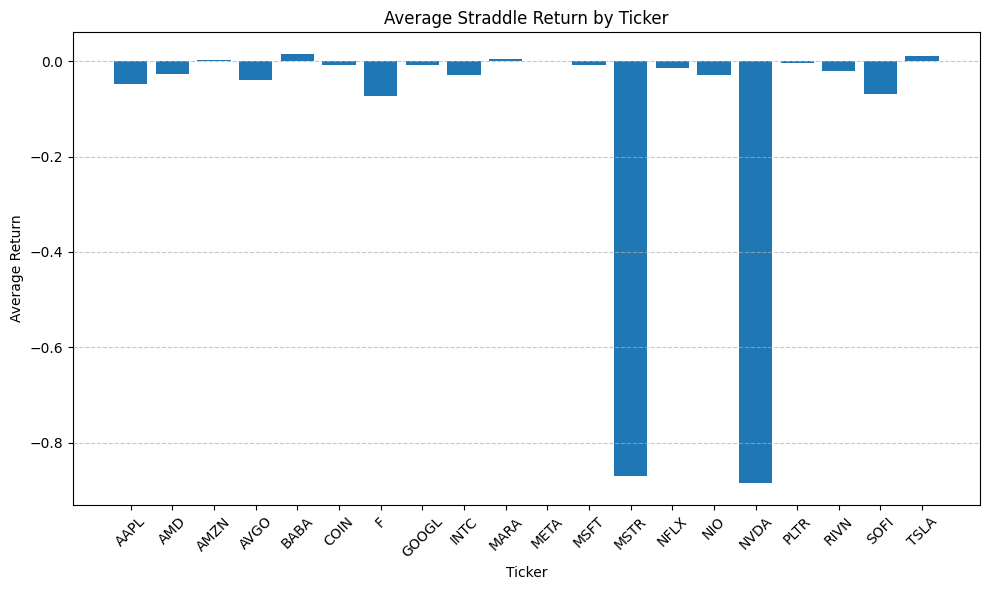

In [48]:
# graphing code for the Average Straddle Return by each Ticker
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import matplotlib.cm as cm

plt.figure(figsize=(10, 6)) 
plt.bar(avg_returns['ticker'], avg_returns['return']) 
plt.xlabel('Ticker')
plt.ylabel('Average Return')
plt.title('Average Straddle Return by Ticker') 
plt.grid(True, axis='y', linestyle='--', alpha=0.7) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
import numpy as np

def compute_stats(group):
    mu = group['return'].mean() 
    sigma = group['return'].std() 
    n = group['return'].count()
    
    sharpe = mu / sigma if sigma != 0 else np.nan
    t_stat = mu / (sigma / np.sqrt(n)) if sigma != 0 else np.nan
    win_rate = (group['return'] > 0).mean()
    
    return pd.Series({ 
        'mean_return': mu, 
        'std_return': sigma, 
        'sharpe_ratio': sharpe,
        'win_rate': win_rate, 
        't_stat': t_stat, 
        'n_obs': n
    })

stats_by_ticker = returns.groupby('ticker').apply(compute_stats).reset_index()

stats_by_ticker.style.format({
    'mean_return': '{:.2%}', 
    'std_return': '{:.2%}', 
    #'sharpe_ratio': '{:.2f}',
    'win_rate': '{:.2%}', 
    #'t_stat': t_stat, 
    'n_obs': '{:.0f}'
})

/var/folders/b1/g827t6qn66l1htcz2y_jj7640000gn/T/ipykernel_2149/4232807503.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_by_ticker = returns.groupby('ticker').apply(compute_stats).reset_index()


,ticker,mean_return,std_return,sharpe_ratio,win_rate,t_stat,n_obs
0,AAPL,-4.82%,20.45%,-0.235630,37.50%,-1.154348,24
1,AMD,-2.79%,14.33%,-0.194856,59.26%,-1.012501,27
2,AMZN,0.29%,3.69%,0.077737,57.69%,0.396385,26
3,AVGO,-4.00%,15.93%,-0.251287,40.00%,-0.561896,5
4,BABA,1.51%,17.68%,0.085275,43.48%,0.408965,23
5,COIN,-0.92%,4.36%,-0.212042,35.29%,-0.874273,17
6,F,-7.38%,19.79%,-0.372725,20.83%,-1.825973,24
7,GOOGL,-0.86%,6.83%,-0.126306,36.00%,-0.631532,25
8,INTC,-2.85%,10.72%,-0.265793,16.00%,-1.328965,25
9,MARA,0.47%,7.54%,0.062626,52.00%,0.313131,25


In [50]:
straddles[straddles['ticker']=='COIN']

,ticker,date,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate
129,COIN,2023-01-20,55.0,10.30,0.01,1.0,1.0,10.31,2023-02-17
130,COIN,2023-02-17,65.0,9.96,0.01,1.0,1.0,9.97,2023-03-17
131,COIN,2023-03-17,75.0,0.01,16.15,1.0,1.0,16.16,2023-04-21
132,COIN,2023-04-21,60.0,0.01,3.12,1.0,1.0,3.13,2023-05-19
133,COIN,2023-05-19,55.0,0.55,0.01,1.0,1.0,0.56,2023-06-16
134,COIN,2023-06-16,55.0,45.93,0.01,1.0,1.0,45.94,2023-07-21
136,COIN,2023-08-18,75.0,7.15,0.01,1.0,1.0,7.16,2023-09-15
137,COIN,2023-09-15,80.0,0.01,5.40,1.0,1.0,5.41,2023-10-20
138,COIN,2023-10-20,75.0,23.94,0.02,1.0,1.0,23.96,2023-11-17
139,COIN,2023-11-17,100.0,47.63,0.01,1.0,1.0,47.64,2023-12-15


# momentum signal construction

In [51]:
months = list(returns['date'].unique()) 
months

[Timestamp('2023-01-20 00:00:00'),
 Timestamp('2023-02-17 00:00:00'),
 Timestamp('2023-03-17 00:00:00'),
 Timestamp('2023-05-19 00:00:00'),
 Timestamp('2023-06-16 00:00:00'),
 Timestamp('2023-07-21 00:00:00'),
 Timestamp('2023-09-15 00:00:00'),
 Timestamp('2023-10-20 00:00:00'),
 Timestamp('2023-12-15 00:00:00'),
 Timestamp('2024-01-19 00:00:00'),
 Timestamp('2024-02-16 00:00:00'),
 Timestamp('2024-03-15 00:00:00'),
 Timestamp('2024-04-19 00:00:00'),
 Timestamp('2024-05-17 00:00:00'),
 Timestamp('2024-06-21 00:00:00'),
 Timestamp('2024-07-19 00:00:00'),
 Timestamp('2024-08-16 00:00:00'),
 Timestamp('2024-09-20 00:00:00'),
 Timestamp('2024-10-18 00:00:00'),
 Timestamp('2024-11-15 00:00:00'),
 Timestamp('2024-12-20 00:00:00'),
 Timestamp('2025-01-17 00:00:00'),
 Timestamp('2025-05-16 00:00:00'),
 Timestamp('2025-06-20 00:00:00'),
 Timestamp('2023-04-21 00:00:00'),
 Timestamp('2023-08-18 00:00:00'),
 Timestamp('2023-11-17 00:00:00')]

In [52]:
monthly_stock_returns

,ticker,date,monthly_return
0,AAPL,2018-02-16,-0.034977
1,AAPL,2018-03-16,0.032719
2,AAPL,2018-04-20,-0.032746
3,AAPL,2018-05-18,0.082118
4,AAPL,2018-06-15,0.020375
...,...,...,...
1718,TSLA,2025-05-16,0.419251
1719,TSLA,2025-06-20,-0.060586
1720,TSLA,2025-07-03,-0.019873
1721,TSLA,2025-07-18,0.011912


In [53]:
# momentum signal construction
import numpy as np
months = list(monthly_stock_returns['date'].unique()) 
LBwin12 = {}
for r in tickers:
    for t in range(12,len(months)): 
        window = []
        for j in range(t-12, t-1): 
            window.append((r,months[j])) 
            LBwin12[(r,months[t])] = window

LBwin12

{('AAPL',
  Timestamp('2019-02-15 00:00:00')): [('AAPL',
   Timestamp('2018-02-16 00:00:00')), ('AAPL',
   Timestamp('2018-03-16 00:00:00')), ('AAPL',
   Timestamp('2018-04-20 00:00:00')), ('AAPL',
   Timestamp('2018-05-18 00:00:00')), ('AAPL',
   Timestamp('2018-06-15 00:00:00')), ('AAPL',
   Timestamp('2018-07-20 00:00:00')), ('AAPL',
   Timestamp('2018-08-17 00:00:00')), ('AAPL',
   Timestamp('2018-09-21 00:00:00')), ('AAPL',
   Timestamp('2018-10-19 00:00:00')), ('AAPL',
   Timestamp('2018-11-16 00:00:00')), ('AAPL',
   Timestamp('2018-12-21 00:00:00'))],
 ('AAPL',
  Timestamp('2019-03-15 00:00:00')): [('AAPL',
   Timestamp('2018-03-16 00:00:00')), ('AAPL',
   Timestamp('2018-04-20 00:00:00')), ('AAPL',
   Timestamp('2018-05-18 00:00:00')), ('AAPL',
   Timestamp('2018-06-15 00:00:00')), ('AAPL',
   Timestamp('2018-07-20 00:00:00')), ('AAPL',
   Timestamp('2018-08-17 00:00:00')), ('AAPL',
   Timestamp('2018-09-21 00:00:00')), ('AAPL',
   Timestamp('2018-10-19 00:00:00')), ('AAPL',
 

In [54]:
def returnlookup(rt: tuple, monthly_stock_returns):
    ticker, date = rt
    mask = (monthly_stock_returns['date'] == date) & (monthly_stock_returns['ticker'] == ticker) 
    filtered = monthly_stock_returns.loc[mask, 'monthly_return']
    if not filtered.empty:
        return filtered.iloc[0] 
    else:
        return None

In [346]:
# ============== Old lbwinr ===============
# def lbwinr(monthly_stock_returns):
#     MOMs = {}
#     LBwinReturn = {}
#     for k, v in LBwin12.items():
#         count = 0 
#         temp_sum = 0 
#         res = []
#         for rt in v:
#             val = returnlookup(rt, monthly_stock_returns)
#             if val: # safer than just "if val", avoids skipping 0 monthly_stock_returns
#                 temp_sum += val 
#                 count += 1 
#                 res.append(val)
        
#         mom = temp_sum / count if count >= 8 else np.nan 
#         LBwinReturn[k] = res
#         MOMs[k] = mom
#     return (LBwinReturn, MOMs)

In [55]:
def lbwinr(monthly_stock_returns):
    LBwinReturn = {}
    MOMs        = {}

    for k, v in LBwin12.items():
        vals = []
        for rt in v:
            val = returnlookup(rt, monthly_stock_returns)
            # only accept real numbers (keep zeros, drop NaN/None)
            if val is not None and pd.notna(val):
                vals.append(val)

        count    = len(vals)
        temp_sum = sum(vals)

        # store the individual returns
        LBwinReturn[k] = vals

        # compute the MOM only if you have at least 8 months
        MOMs[k] = (temp_sum / count) if count >= 8 else np.nan

    return LBwinReturn, MOMs

In [56]:
LBwinReturn, MOMs = lbwinr(monthly_stock_returns)

In [57]:
MOMs_df = pd.DataFrame([(k1, k2, v) for (k1, k2), v in MOMs.items()], columns=['ticker', 'date', 'MOM'])
MOMs_df['MOM'] = MOMs_df['MOM'].abs()
MOMs_df

,ticker,date,MOM
0,AAPL,2019-02-15,0.008770
1,AAPL,2019-03-15,0.006152
2,AAPL,2019-04-18,0.000413
3,AAPL,2019-05-17,0.009446
4,AAPL,2019-06-21,0.011580
...,...,...,...
1635,TSLA,2025-05-16,0.069397
1636,TSLA,2025-06-20,0.056329
1637,TSLA,2025-07-03,0.090943
1638,TSLA,2025-07-18,0.051559


In [58]:
MOMs_df.to_csv('Stock_MOM_08_25.csv', index = False)

In [59]:
avg_moms = MOMs_df.groupby('ticker')['MOM'].mean().reset_index() 
avg_moms

,ticker,MOM
0,AAPL,0.024573
1,AMD,0.048131
2,AMZN,0.024064
3,AVGO,0.033968
4,BABA,0.027564
5,COIN,0.071959
6,F,0.022913
7,GOOGL,0.023326
8,INTC,0.022136
9,MARA,0.137515


In [60]:
std_moms = MOMs_df.groupby('ticker')['MOM'].std().reset_index() 
std_moms

,ticker,MOM
0,AAPL,0.019824
1,AMD,0.026749
2,AMZN,0.016575
3,AVGO,0.020307
4,BABA,0.020178
5,COIN,0.047813
6,F,0.023963
7,GOOGL,0.015019
8,INTC,0.016164
9,MARA,0.182747


### visualizations

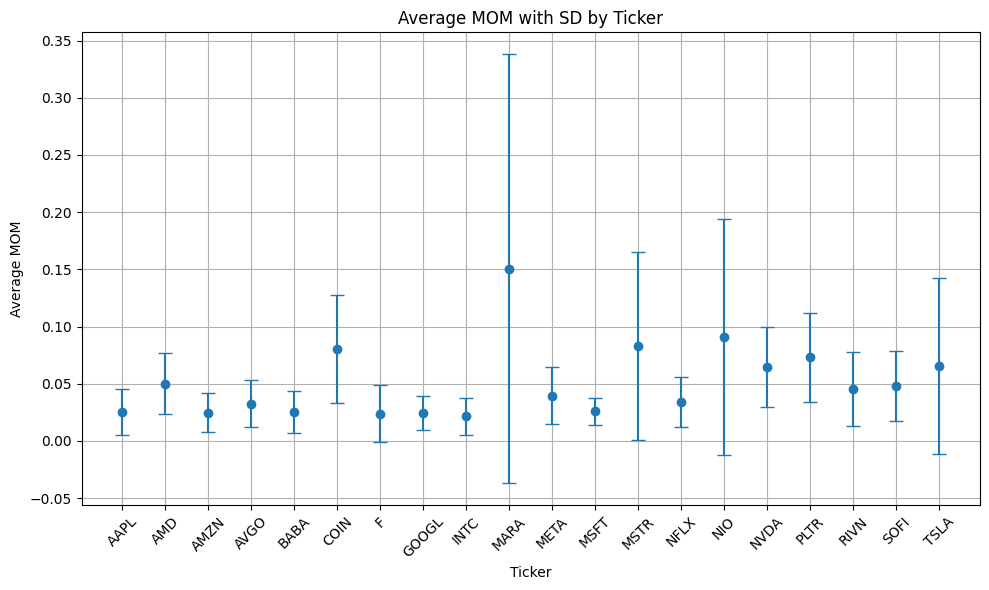

In [646]:
summary_MOMs = MOMs_df.groupby('ticker')['MOM'].agg(['mean', 'std']).reset_index()
plt.figure(figsize=(10, 6))
plt.errorbar(summary_MOMs['ticker'], summary_MOMs['mean'], yerr=summary_MOMs['std'], fmt='o', capsize=5) 
plt.xlabel('Ticker')
plt.ylabel('Average MOM')
plt.title('Average MOM with SD by Ticker')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

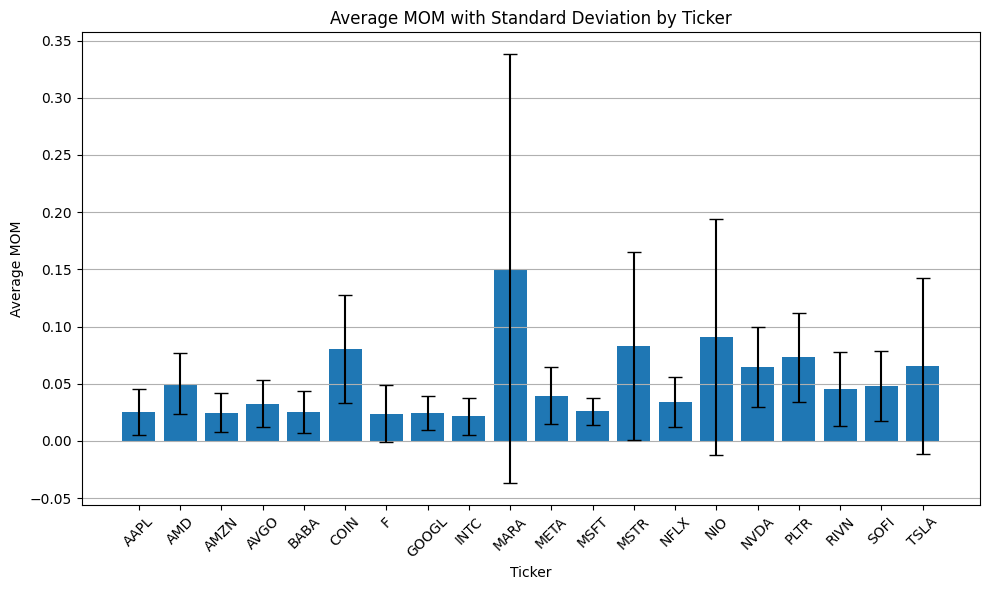

In [647]:
plt.figure(figsize=(10, 6))
plt.bar(summary_MOMs['ticker'], summary_MOMs['mean'], yerr=summary_MOMs['std'], capsize=5) 
plt.xlabel('Ticker')
plt.ylabel('Average MOM')
plt.title('Average MOM with Standard Deviation by Ticker')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [648]:
MOMs_df

,ticker,date,MOM
0,AAPL,2019-02-15,0.008770
1,AAPL,2019-03-15,0.006152
2,AAPL,2019-04-18,0.000413
3,AAPL,2019-05-17,0.009446
4,AAPL,2019-06-21,0.011580
...,...,...,...
1475,TSLA,2024-09-20,0.004703
1476,TSLA,2024-10-18,0.010323
1477,TSLA,2024-11-15,0.017398
1478,TSLA,2024-12-20,0.002020


In [551]:
# import seaborn as sns
# # Ensure 'date' is treated as a tuple (y, m) for consistent pivoting
# MOMs_df['date_tuple'] = MOMs_df['date'].apply(lambda x: (x.year, x.month)) # Pivot the table: rows = date, columns = ticker, values = MOM
# heatmap_data = MOMs_df.pivot(index='date_tuple', columns='ticker', values='MOM') # Sort index (date) just in case
# heatmap_data = heatmap_data.sort_index()
# plt.figure(figsize=(14, 8)) 
# sns.heatmap(heatmap_data.transpose(), cmap="coolwarm", center=0) 
# plt.title("MOM$_{t}$ Signal Across Tickers and Time") 
# plt.xlabel("Date (Year, Month)")
# plt.ylabel("Ticker")
# plt.tight_layout()
# plt.show()

<Axes: xlabel='ym', ylabel='ticker'>

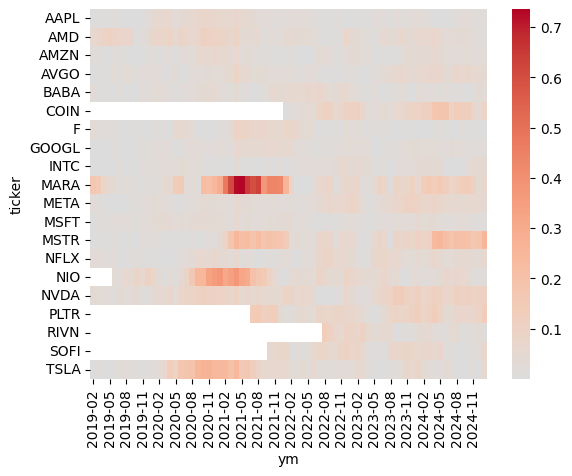

In [649]:
MOMs_df['ym'] = MOMs_df['date'].dt.to_period('M')

heatmap_data = (
    MOMs_df.pivot_table(index='ym', columns='ticker', values='MOM', aggfunc='mean')
            .sort_index()
)
sns.heatmap(heatmap_data.T, cmap="coolwarm", center=0)

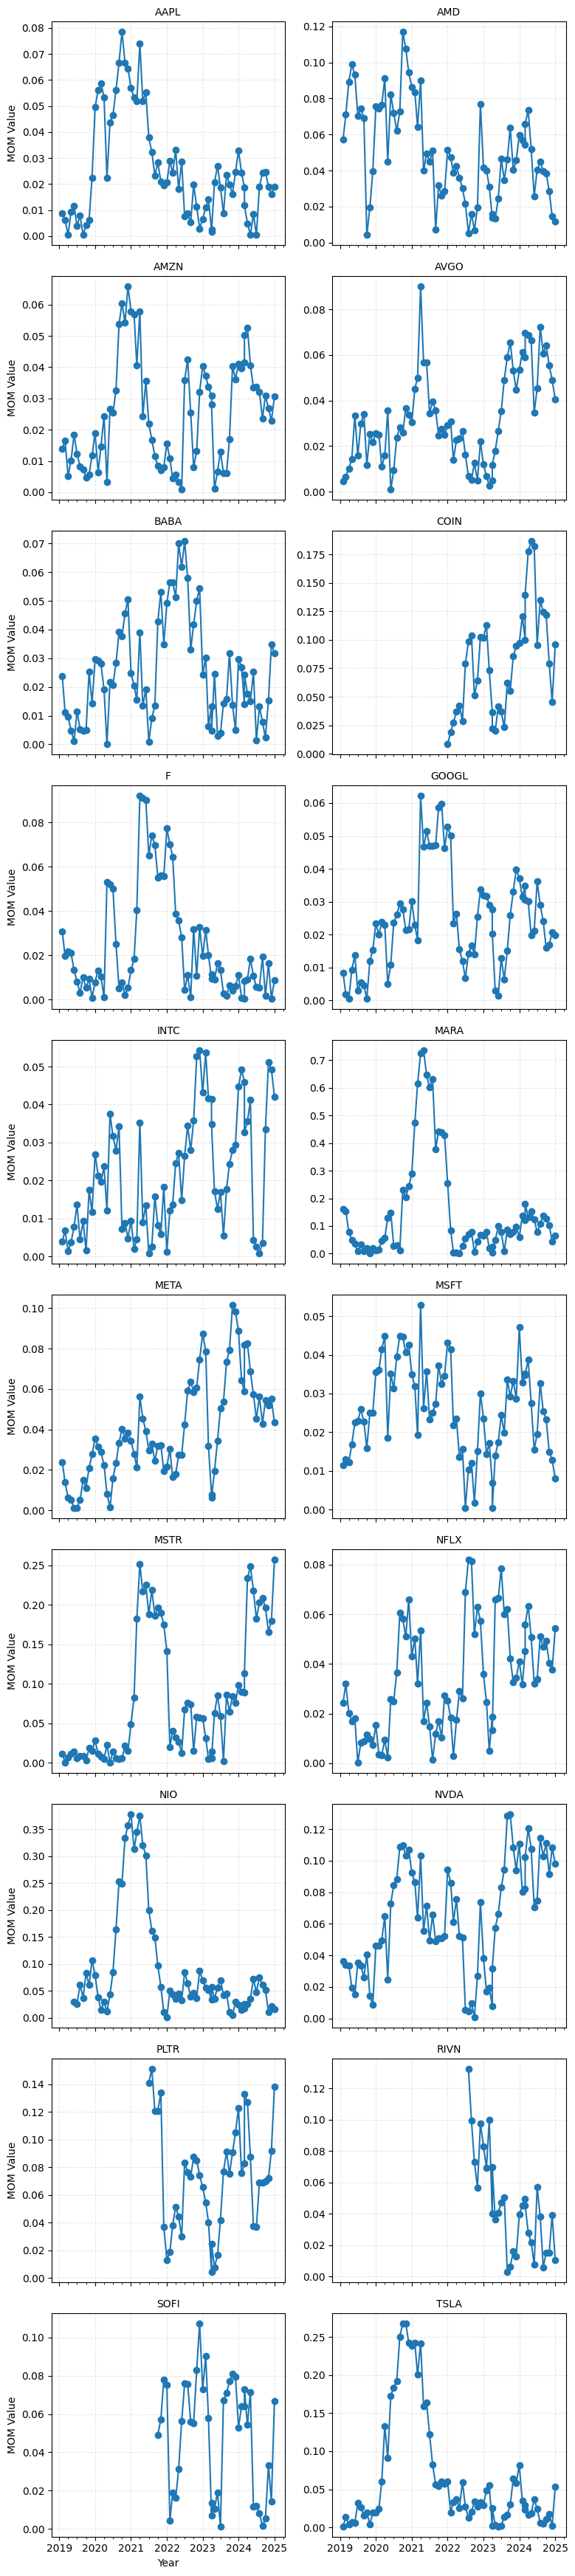

In [650]:

MOMs_df['date_dt'] = MOMs_df['date'].dt.to_period('M').dt.to_timestamp()
tickers = MOMs_df['ticker'].unique() 
n_tickers = len(tickers)
n_cols = 2
n_rows = math.ceil(n_tickers / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows), sharex=True) 
axes_list = axes.flatten() if hasattr(axes, 'flatten') else [axes]

for idx, t in enumerate(tickers):
    ax = axes_list[idx]
    sub = MOMs_df[MOMs_df['ticker'] == t].sort_values('date_dt') 
    x = sub['date_dt'].values
    y = sub['MOM'].values.astype(float)
    ax.plot(x, y, marker='o', linestyle='-')
    ax.set_title(t, fontsize=10)
    ax.grid(linestyle='--', alpha=0.3)
    if idx % n_cols == 0:
        ax.set_ylabel('MOM Value') 
        if idx // n_cols == n_rows - 1:
            ax.set_xlabel('Year') 
            ax.xaxis.set_major_locator(mdates.YearLocator()) 
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
            ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10])) 
            ax.xaxis.set_minor_formatter(mdates.DateFormatter(''))

for j in range(n_tickers, n_rows * n_cols): 
    axes_list[j].axis('off')

plt.tight_layout() 
plt.show()

/var/folders/b1/g827t6qn66l1htcz2y_jj7640000gn/T/ipykernel_35370/666427885.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(tickers))


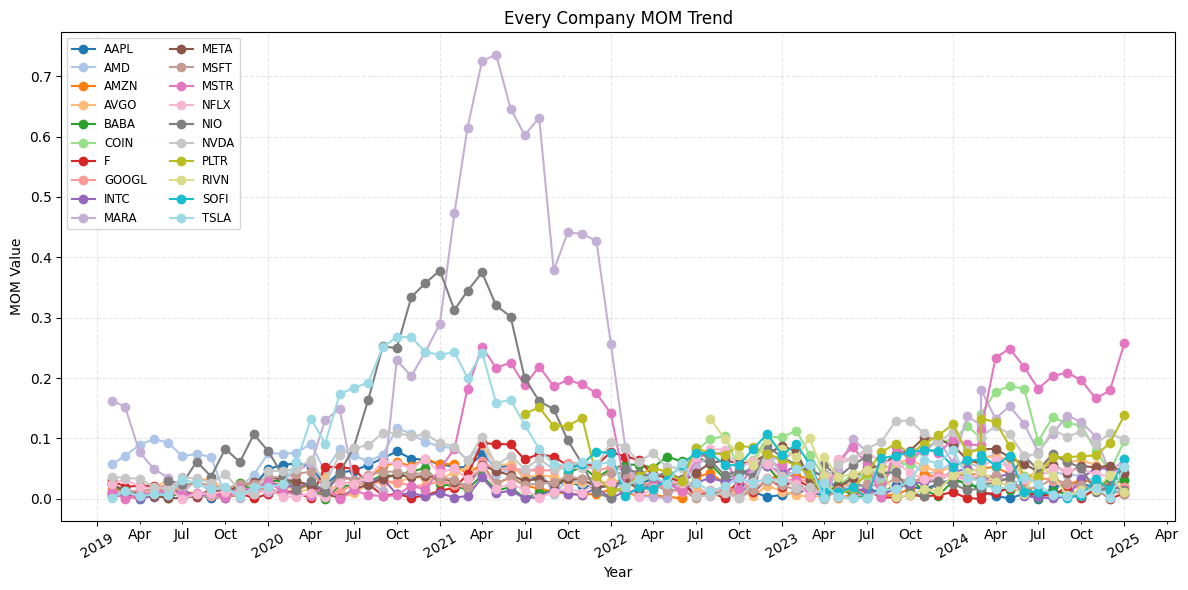

In [651]:
MOMs_df['date_dt'] = MOMs_df['date'].dt.to_period('M').dt.to_timestamp()

plt.figure(figsize=(12, 6))
tickers = MOMs_df['ticker'].unique()
cmap = cm.get_cmap('tab20', len(tickers))
for idx, t in enumerate(tickers):
    sub = MOMs_df[MOMs_df['ticker'] == t].sort_values('date_dt')
    plt.plot(sub['date_dt'], sub['MOM'], marker='o', linestyle='-', label=t, color=cmap(idx))

plt.xlabel('Year')
plt.ylabel('MOM Value') 
plt.title('Every Company MOM Trend')
plt.legend(loc='upper left', fontsize='small', ncol=2) 
plt.grid(linestyle='--', alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10])) 
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

plt.xticks(rotation=30) 
plt.tight_layout() 
plt.show()


# Extension: Sort by IV skew and control for IV effects

In [ ]:
# # Extension: Sort by IV skew and control for IV effects
# import pandas as pd
# options['bid_ask_spread'] = options['best_offer'] - options['best_bid']
# put_delta_range = (-0.3, -0.2) 
# call_delta_range = (0.2, 0.3)
# puts = options[(options['cp_flag'] == 'P') & (options['delta'].between(*put_delta_range))]
# calls = options[(options['cp_flag'] == 'C') & (options['delta'].between(*call_delta_range))]
# # Pick contract with narrowest spread per (ticker, date)
# puts_narrowest = puts.sort_values('bid_ask_spread').groupby(['ticker', 'date']).first().reset_index() 
# calls_narrowest = calls.sort_values('bid_ask_spread').groupby(['ticker', 'date']).first().reset_index()
# # Merge the two
# merged = pd.merge(
#     puts_narrowest[['ticker', 'date', 'impl_volatility']], 
#     calls_narrowest[['ticker', 'date', 'impl_volatility']], 
#     on=['ticker', 'date'],
#     suffixes=('_25', '_75')
# )
# # Compute skew and level
# merged['IVSkew'] = merged['impl_volatility_25'] - merged['impl_volatility_75'] 
# merged['IVLevel'] = (merged['impl_volatility_25'] + merged['impl_volatility_75']) / 2
# # Rename columns
# merged.rename(columns={
#     'ticker': 'ticker',
#     'date': 'date', 
#     'impl_volatility_25': 'IV_25', 
#     'impl_volatility_75': 'IV_75'
#     }, inplace=True)
# # Final panel
# iv_panel = merged[['ticker', 'date', 'IV_25', 'IV_75', 'IVSkew', 'IVLevel']]

KeyError: 'best_offer'

# Step 6: Form Momentum Portfolios

## Quintile (Not required for now)

In [ ]:
# Q = 5 # use quintiles as for now

# def get_top_quantile(x):
#     valid = x[x['MOM'].notna()]  # only look at the tickers which have MOM value
#     n = max(1, len(valid)//Q)
#     return valid.nlargest(n, 'MOM')

# def get_bot_quantile(x):
#     valid = x[x['MOM'].notna()]
#     n = max(1, len(valid)//Q)
#     return valid.nsmallest(n, 'MOM')

# top = MOMs_df.groupby('date', group_keys=False).apply(get_top_quantile).reset_index(drop=True)
# bot = MOMs_df.groupby('date', group_keys=False).apply(get_bot_quantile).reset_index(drop=True)


/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_46451/2359375352.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top = MOMs_df.groupby('date', group_keys=False).apply(get_top_quantile).reset_index(drop=True)
/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_46451/2359375352.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bot = MOMs_df.groupby('date', group_keys=False).apply(get_bot_quant

In [ ]:
# MOMs_df[(MOMs_df['ticker'] == 'TSLA')]

,ticker,date,MOM,signal
882,TSLA,2019-01-18,0.021044,None
883,TSLA,2019-02-15,0.003914,None
884,TSLA,2019-03-15,-0.000242,None
885,TSLA,2019-04-19,0.023952,LS
886,TSLA,2019-05-17,0.003092,None
887,TSLA,2019-06-21,-0.007445,SS
888,TSLA,2019-07-19,-0.046421,SS
889,TSLA,2019-08-16,-0.015739,SS
890,TSLA,2019-09-20,-0.009428,SS
891,TSLA,2019-10-18,-0.004331,None


## 从这里开始

In [652]:
# rank momentums
def get_sorted_tickers(momentum_df, reverse=True):
    return momentum_df.sort_values('MOM', ascending=not reverse)['ticker'].tolist()


def pick_available_tickers(ticker_list, this_month, next_month, returns_df, n=3):
    picked = []
    for ticker in ticker_list:
        has_this_month = not returns_df[(returns_df['ticker'] == ticker) & (returns_df['date'] == this_month)].empty
        has_next_month = not returns_df[(returns_df['ticker'] == ticker) & (returns_df['date'] == next_month)].empty
        if has_this_month and has_next_month:
            picked.append(ticker)
            if len(picked) == n:
                break
    return picked


In [363]:
# LSReturns = {} # long-short portfolio return
# Qhigh = {} # top quantile return
# Qlow = {} # bottom quantile return 

# MOMs_df['date'] = pd.to_datetime(MOMs_df['date']).dt.date
# returns['date'] = pd.to_datetime(returns['date']).dt.date
# months = [pd.to_datetime(m).date() for m in months]

# # form momentum portfolios
# for t in range(12, len(months)-1):
#     # sort out the highest momentum group and the lowest momentum group
#     key = months[t]         
#     next_month = months[t+1]

#     # 按当前月份筛选
#     this_mom_df = MOMs_df[MOMs_df['date'] == key]
#     sorted_top = get_sorted_tickers(this_mom_df, reverse=True)
#     sorted_bot = get_sorted_tickers(this_mom_df, reverse=False)

#     # 动态补齐top3/bot3
#     q1 = pick_available_tickers(sorted_top, key, next_month, returns, n=3)
#     q2 = pick_available_tickers(sorted_bot, key, next_month, returns, n=3)

#     MOMs_df.loc[(MOMs_df['date'] == key) & (MOMs_df['ticker'].isin(q1)), 'signal'] = 'LS'
#     MOMs_df.loc[(MOMs_df['date'] == key) & (MOMs_df['ticker'].isin(q2)), 'signal'] = 'SS'

#     sum1, sum2 = 0, 0
#     for r in q1:
#         val = returns[
#             (returns['ticker'] == r) & 
#             # calculate the average return of the highest momentum group at t+1 
#             (returns['date'] == months[t+1])
#         ]['return']
        
#         if not val.empty:
#             sum1 += val.values[0]

#     for r in q2:
#         val = returns[
#             (returns['ticker'] == r) &
#             # calculate the average return of the lowest momentum group at t+1 
#             (returns['date'] == months[t+1])
#         ]['return']
    
#         if not val.empty:
#             sum2 += val.values[0]
    
#     if q1 and q2:
#         ret_q1 = max(min(sum1 / len(q1), 2.0), -2.0) 
#         ret_q2 = max(min(sum2 / len(q2), 2.0), -2.0) 
#         #add a individual leg returns of bound +-200% 
#         # # construct the long term return
#         Qhigh[months[t].strftime('%Y-%m-%d')] = ret_q1
#         Qlow[months[t].strftime('%Y-%m-%d')] = ret_q2
#         LSReturns[months[t].strftime('%Y-%m-%d')] = ret_q1 - ret_q2

        

In [364]:
# ==================== Previous Loop ====================
# # 0) Ensure your date columns are real Timestamps (datetime64[ns])
# MOMs_df['date'] = pd.to_datetime(MOMs_df['date'])
# returns ['date'] = pd.to_datetime(returns ['date'])

# # 1) Drop any rows in returns whose date didn’t map (NaT)
# returns = returns.dropna(subset=['date'])

# # 2) Build a sorted list of all signal dates
# months = sorted( returns['date'].unique() )

# # 3) Prepare your output containers
# LSReturns = {}   # long–short returns by signal month
# Qhigh     = {}   # top‐quantile returns
# Qlow      = {}   # bottom‐quantile returns

# # 4) Main loop: pick, fallback, compute next‐month returns
# for t in range(12, len(months) - 1):
#     this_month = months[t]
#     next_month = months[t + 1]
#     label      = this_month.strftime('%Y-%m-%d')

#     # filter the momentum DataFrame to this signal date
#     this_mom_df = MOMs_df.loc[MOMs_df['date'] == this_month]

#     # get sorted tickers by MOM
#     sorted_top = get_sorted_tickers(this_mom_df, reverse=True)
#     sorted_bot = get_sorted_tickers(this_mom_df, reverse=False)

#     # fallback: fill to 3 tickers if any are missing next_month
#     q1 = pick_available_tickers(sorted_top,  this_month, next_month, returns, n=3)
#     q2 = pick_available_tickers(sorted_bot, this_month, next_month, returns, n=3)

#     # (optional) tag your signals in MOMs_df
#     MOMs_df.loc[
#         (MOMs_df['date'] == this_month) & MOMs_df['ticker'].isin(q1),
#         'signal'
#     ] = 'LS'
#     MOMs_df.loc[
#         (MOMs_df['date'] == this_month) & MOMs_df['ticker'].isin(q2),
#         'signal'
#     ] = 'SS'

#     # sum next‐month returns for each group, skipping any missing
#     sum1 = sum(
#         returns.loc[
#             (returns['ticker'] == r) & (returns['date'] == next_month),
#             'return'
#         ].iloc[0]
#         for r in q1
#         if not returns[
#             (returns['ticker'] == r) & (returns['date'] == next_month)
#         ].empty
#     )
#     sum2 = sum(
#         returns.loc[
#             (returns['ticker'] == r) & (returns['date'] == next_month),
#             'return'
#         ].iloc[0]
#         for r in q2
#         if not returns[
#             (returns['ticker'] == r) & (returns['date'] == next_month)
#         ].empty
#     )

#     # record only if both groups are non‐empty
#     if q1 and q2:
#         ret_q1 = max(min(sum1 / len(q1),  2.0), -2.0)
#         ret_q2 = max(min(sum2 / len(q2),  2.0), -2.0)

#         Qhigh    [label] = ret_q1
#         Qlow     [label] = ret_q2
#         LSReturns[label] = ret_q1 - ret_q2

In [653]:
# ==================== New Loop ====================

# 0) Ensure your date columns are datetime64[ns]
MOMs_df['date'] = pd.to_datetime(MOMs_df['date'])
returns ['date'] = pd.to_datetime(returns ['date'])

# 1) Drop any rows in `returns` where the date snapped to NaT
returns = returns.dropna(subset=['date'])

# 2) Build your list of **signal** months from MOMs_df (not from returns)
signal_months = sorted(MOMs_df['date'].unique())

# 3) Prepare your output containers
LSReturns = {}   # long–short returns by signal month
Qhigh     = {}   # top‐quantile returns
Qlow      = {}   # bottom‐quantile returns

# 4) Main loop: iterate only over actual signal months
for this_month, next_month in zip(signal_months, signal_months[1:]):
    label      = this_month.strftime('%Y-%m-%d')
    
    # subset the momentum DataFrame to this signal date
    this_mom_df = MOMs_df.loc[MOMs_df['date'] == this_month]

    # rank tickers by absolute MOM (or signed, if you prefer)
    sorted_top = get_sorted_tickers(this_mom_df, reverse=True)
    sorted_bot = get_sorted_tickers(this_mom_df, reverse=False)

    # fallback: pick up to 3 tickers that have BOTH this_month & next_month returns
    q1 = pick_available_tickers(sorted_top,  this_month, next_month, returns, n=3)
    q2 = pick_available_tickers(sorted_bot, this_month, next_month, returns, n=3)

    # tag the signals (optional)
    MOMs_df.loc[
        (MOMs_df['date'] == this_month) & MOMs_df['ticker'].isin(q1),
        'signal'
    ] = 'LS'
    MOMs_df.loc[
        (MOMs_df['date'] == this_month) & MOMs_df['ticker'].isin(q2),
        'signal'
    ] = 'SS'

    # sum next‐month returns for each group, skipping missing
    sum1 = sum(
        returns.loc[
            (returns['ticker'] == r) & (returns['date'] == next_month),
            'return'
        ].iloc[0]
        for r in q1
        if not returns[
            (returns['ticker'] == r) & (returns['date'] == next_month)
        ].empty
    )
    sum2 = sum(
        returns.loc[
            (returns['ticker'] == r) & (returns['date'] == next_month),
            'return'
        ].iloc[0]
        for r in q2
        if not returns[
            (returns['ticker'] == r) & (returns['date'] == next_month)
        ].empty
    )

    # record only if both legs are non‐empty
    if q1 and q2:
        ret_q1 = max(min(sum1 / len(q1),  2.0), -2.0)
        ret_q2 = max(min(sum2 / len(q2),  2.0), -2.0)
        Qhigh    [label] = ret_q1
        Qlow     [label] = ret_q2
        LSReturns[label] = ret_q1 - ret_q2

# 5) (Optional) assemble your results into a DataFrame
momentums_return_corrected_v3 = (
    pd.DataFrame.from_dict(LSReturns, orient='index', columns=['Long-Short'])
      .rename_axis('Month')
      .reset_index()
)
momentums_return_corrected_v3['Month'] = (
    pd.to_datetime(momentums_return_corrected_v3['Month'])
      .dt.to_period('M')
      .astype(str)
)


In [654]:
# save the long-short returns into the DataFrame
longShortReturns = pd.DataFrame(list(LSReturns.items()), columns=['Month', 'Long-Short return'])
longShortReturns['Month'] = pd.to_datetime(longShortReturns['Month']).dt.strftime('%Y-%m')
longShortReturns

,Month,Long-Short return
0,2023-01,0.321515
1,2023-02,0.006022
2,2023-04,0.003576
3,2023-05,-0.008464
4,2023-06,-0.052563
5,2023-07,0.025663
6,2023-08,0.007523
7,2023-09,-0.042631
8,2023-10,0.006712
9,2023-11,0.045408


In [655]:
longShortReturns['Long-Short return'].mean()

np.float64(0.01881552361849532)

In [656]:
MOMs_copy = MOMs_df.copy()
MOMs_copy.sort_values('date').head(50)

,ticker,date,MOM,ym,date_dt,signal
0,AAPL,2019-02-15,0.008770,2019-02,2019-02-01,NaN
1110,NVDA,2019-02-15,0.036410,2019-02,2019-02-01,NaN
888,MSTR,2019-02-15,0.011486,2019-02,2019-02-01,NaN
74,AMD,2019-02-15,0.057222,2019-02,2019-02-01,NaN
814,MSFT,2019-02-15,0.011487,2019-02,2019-02-01,NaN
1184,PLTR,2019-02-15,NaN,2019-02,2019-02-01,NaN
740,META,2019-02-15,0.023888,2019-02,2019-02-01,NaN
148,AMZN,2019-02-15,0.013881,2019-02,2019-02-01,NaN
962,NFLX,2019-02-15,0.024435,2019-02,2019-02-01,NaN
666,MARA,2019-02-15,0.162438,2019-02,2019-02-01,NaN


##############################

In [369]:
# # fix n=3

# def get_top_quantile(x):
#     valid = x[x['MOM'].notna()]  # only look at the tickers which have MOM value
#     n = 3
#     return valid.nlargest(n, 'MOM')

# def get_bot_quantile(x):
#     valid = x[x['MOM'].notna()]
#     n = 3
#     return valid.nsmallest(n, 'MOM')

# top = MOMs_df.groupby('date', group_keys=False).apply(get_top_quantile).reset_index(drop=True)
# bot = MOMs_df.groupby('date', group_keys=False).apply(get_bot_quantile).reset_index(drop=True)


In [158]:
# top_pairs = set(zip(top['date'], top['ticker']))
# bot_pairs = set(zip(bot['date'], bot['ticker']))

# def assign_signal(row):
#     if (row['date'], row['ticker']) in top_pairs:
#         return 'LS'
#     elif (row['date'], row['ticker']) in bot_pairs:
#         return 'SS'
#     else:
#         return None

# MOMs_df['signal'] = MOMs_df.apply(assign_signal, axis=1)


In [159]:
# MOMs_df

In [160]:
# MOMs_df = MOMs_df.drop(columns=['date_tuple', 'date_dt'])

In [161]:
# months[t]

In [162]:
# LSReturns = {} # long-short portfolio return
# Qhigh = {} # top quantile return
# Qlow = {} # bottom quantile return 

# # form momentum portfolios
# for t in range(12, len(months)-1):
#     # sort out the highest momentum group and the lowest momentum group
#     key = str(months[t].date())
#     q1 = list(top[top['date'] == key]['ticker'])
#     q2 = list(bot[bot['date'] == key]['ticker'])
#     sum1, sum2 = 0, 0
#     for r in q1:
#         val = returns[
#             (returns['ticker'] == r) & 
#             # calculate the average return of the highest momentum group at t+1 
#             (returns['date'] == months[t+1])
#         ]['return']
        
#         if not val.empty:
#             sum1 += val.values[0]

#     for r in q2:
#         val = returns[
#             (returns['ticker'] == r) &
#             # calculate the average return of the lowest momentum group at t+1 
#             (returns['date'] == months[t+1])
#         ]['return']
    
#         if not val.empty:
#             sum2 += val.values[0]
    
#     if q1 and q2:
#         ret_q1 = max(min(sum1 / len(q1), 2.0), -2.0) 
#         ret_q2 = max(min(sum2 / len(q2), 2.0), -2.0) 
#         #add a individual leg returns of bound +-200% 
#         # # construct the long term return
#         Qhigh[months[t].strftime('%Y-%m-%d')] = ret_q1
#         Qlow[months[t].strftime('%Y-%m-%d')] = ret_q2
#         LSReturns[months[t].strftime('%Y-%m-%d')] = ret_q1 - ret_q2

        

In [163]:
# ====================== Repeated ======================
# # 0) make sure all your date columns are real datetimes
# returns['date'] = pd.to_datetime(returns['date'])
# top   ['date'] = pd.to_datetime(top['date'])
# bot   ['date'] = pd.to_datetime(bot['date'])

# # 1) get a sorted list of unique month-end (or 3rd-Friday) dates
# months = sorted( returns['date'].dropna().unique() )

# # 2) initialize your dicts
# LSReturns = {} # long-short portfolio return
# Qhigh = {} # top quantile return
# Qlow = {} # bottom quantile return 

# # form momentum portfolios
# for t in range(12, len(months)-1):
#     # sort out the highest momentum group and the lowest momentum group
#     this_month = months[t]
#     next_month = months[t + 1]
#     label      = this_month.strftime('%Y-%m-%d')

#     raw_top  = top.loc[top['date']==this_month, 'ticker'].tolist()
#     raw_bot  = bot.loc[bot['date']==this_month, 'ticker'].tolist()

#     # pull in the next-available if someone is missing
#     q1 = pick_available_tickers(raw_top, this_month, next_month, returns, n=len(raw_top))
#     q2 = pick_available_tickers(raw_bot, this_month, next_month, returns, n=len(raw_bot))
    
#     # sum next-month returns for each group
#     sum1 = 0.0
#     for r in q1:
#         vals = returns.loc[
#             (returns['ticker'] == r) &
#             (returns['date']   == next_month),
#             'return'
#         ]
#         if not vals.empty:
#             sum1 += vals.iloc[0]

#     sum2 = 0.0
#     for r in q2:
#         vals = returns.loc[
#             (returns['ticker'] == r) &
#             (returns['date']   == next_month),
#             'return'
#         ]
#         if not vals.empty:
#             sum2 += vals.iloc[0]

#     # record only if both quantiles are non-empty
#     if q1 and q2:
#         ret_q1 = max(min(sum1 / len(q1),  2.0), -2.0)
#         ret_q2 = max(min(sum2 / len(q2),  2.0), -2.0)

#         Qhigh    [label] = ret_q1
#         Qlow     [label] = ret_q2
#         LSReturns[label] = ret_q1 - ret_q2

        

In [164]:
# # save the long-short returns into the DataFrame
# longShortReturns = pd.DataFrame(list(LSReturns.items()), columns=['Month', 'Long-Short return'])
# longShortReturns['Month'] = pd.to_datetime(longShortReturns['Month']).dt.strftime('%Y-%m')
# longShortReturns

In [165]:
# longShortReturns['Long-Short return'].mean()

####################################

## Save to excel

In [657]:
!pip install xlsxwriter


In [658]:
#straddles['date'] = pd.to_datetime(straddles['date'])
straddles['date'] = pd.to_datetime(straddles['date']).dt.strftime('%Y-%m-%d')
returns['date'] = pd.to_datetime(returns['date']).dt.strftime('%Y-%m-%d')


In [659]:
# # ====================== dicarded code ======================

# # Keep dates as datetime objects initially
# straddles['date'] = pd.to_datetime(straddles['date'])
# returns['date'] = pd.to_datetime(returns['date'])

# # Ensure returns has all necessary dates
# print(f"Straddles date range: {straddles['date'].min()} to {straddles['date'].max()}")
# print(f"Returns date range: {returns['date'].min()} to {returns['date'].max()}")

In [660]:
returns.to_csv('returns_before_merge_corrected_25_v2.csv', index = False)

In [661]:
straddles_w_return = straddles.merge(
    returns,
    on=['ticker', 'date'],
    how='left'   
)
straddles_w_return

,ticker,date,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate,return
0,AAPL,2023-01-20,140.0,12.35,0.01,1.0,1.0,12.36,2023-02-17,0.015372
1,AAPL,2023-02-17,155.0,0.10,0.03,1.0,1.0,0.13,2023-03-17,-1.000000
2,AAPL,2023-03-17,155.0,10.05,0.01,1.0,1.0,10.06,2023-04-21,-0.003976
3,AAPL,2023-05-19,175.0,9.99,0.01,1.0,1.0,10.00,2023-06-16,-0.008000
4,AAPL,2023-06-16,185.0,6.86,0.01,1.0,1.0,6.87,2023-07-21,0.010190
...,...,...,...,...,...,...,...,...,...,...
326,TSLA,2024-02-16,200.0,0.01,36.34,1.0,1.0,36.35,2024-03-15,0.002201
327,TSLA,2024-04-19,145.0,32.11,0.01,1.0,1.0,32.12,2024-05-17,0.010586
328,TSLA,2024-06-21,185.0,54.90,0.01,1.0,1.0,54.91,2024-07-19,-0.012930
329,TSLA,2024-07-19,240.0,0.01,23.55,1.0,1.0,23.56,2024-08-16,0.013583


In [662]:
straddles_w_return[(straddles_w_return['date']=='2019-01-18') & (straddles_w_return['ticker']=='GOOGL')]

,ticker,date,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate,return


In [663]:
straddles_w_return

,ticker,date,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate,return
0,AAPL,2023-01-20,140.0,12.35,0.01,1.0,1.0,12.36,2023-02-17,0.015372
1,AAPL,2023-02-17,155.0,0.10,0.03,1.0,1.0,0.13,2023-03-17,-1.000000
2,AAPL,2023-03-17,155.0,10.05,0.01,1.0,1.0,10.06,2023-04-21,-0.003976
3,AAPL,2023-05-19,175.0,9.99,0.01,1.0,1.0,10.00,2023-06-16,-0.008000
4,AAPL,2023-06-16,185.0,6.86,0.01,1.0,1.0,6.87,2023-07-21,0.010190
...,...,...,...,...,...,...,...,...,...,...
326,TSLA,2024-02-16,200.0,0.01,36.34,1.0,1.0,36.35,2024-03-15,0.002201
327,TSLA,2024-04-19,145.0,32.11,0.01,1.0,1.0,32.12,2024-05-17,0.010586
328,TSLA,2024-06-21,185.0,54.90,0.01,1.0,1.0,54.91,2024-07-19,-0.012930
329,TSLA,2024-07-19,240.0,0.01,23.55,1.0,1.0,23.56,2024-08-16,0.013583


In [664]:
straddles_w_return.to_csv("straddles_return_25_corrected_v2.csv")

In [665]:
straddles_w_return['date'] = pd.to_datetime(straddles_w_return['date']).dt.strftime('%Y-%m-%d')
merged_updated['date'] = pd.to_datetime(merged_updated['date']).dt.strftime('%Y-%m-%d')

In [666]:
straddles_w_secid = straddles_w_return.merge(
    merged_updated[['date', 'ticker']],
    on=['ticker', 'date'],
    how='left'   
)
straddles_w_secid

,ticker,date,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate,return
0,AAPL,2023-01-20,140.0,12.35,0.01,1.0,1.0,12.36,2023-02-17,0.015372
1,AAPL,2023-01-20,140.0,12.35,0.01,1.0,1.0,12.36,2023-02-17,0.015372
2,AAPL,2023-01-20,140.0,12.35,0.01,1.0,1.0,12.36,2023-02-17,0.015372
3,AAPL,2023-01-20,140.0,12.35,0.01,1.0,1.0,12.36,2023-02-17,0.015372
4,AAPL,2023-01-20,140.0,12.35,0.01,1.0,1.0,12.36,2023-02-17,0.015372
...,...,...,...,...,...,...,...,...,...,...
30229,TSLA,2024-09-20,240.0,0.01,19.10,1.0,1.0,19.11,2024-10-18,0.009943
30230,TSLA,2024-09-20,240.0,0.01,19.10,1.0,1.0,19.11,2024-10-18,0.009943
30231,TSLA,2024-09-20,240.0,0.01,19.10,1.0,1.0,19.11,2024-10-18,0.009943
30232,TSLA,2024-09-20,240.0,0.01,19.10,1.0,1.0,19.11,2024-10-18,0.009943


In [667]:
straddles_w_secid = straddles_w_secid.drop_duplicates()
straddles_w_secid

,ticker,date,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate,return
0,AAPL,2023-01-20,140.0,12.35,0.01,1.0,1.0,12.36,2023-02-17,0.015372
104,AAPL,2023-02-17,155.0,0.10,0.03,1.0,1.0,0.13,2023-03-17,-1.000000
208,AAPL,2023-03-17,155.0,10.05,0.01,1.0,1.0,10.06,2023-04-21,-0.003976
304,AAPL,2023-05-19,175.0,9.99,0.01,1.0,1.0,10.00,2023-06-16,-0.008000
396,AAPL,2023-06-16,185.0,6.86,0.01,1.0,1.0,6.87,2023-07-21,0.010190
...,...,...,...,...,...,...,...,...,...,...
29210,TSLA,2024-02-16,200.0,0.01,36.34,1.0,1.0,36.35,2024-03-15,0.002201
29486,TSLA,2024-04-19,145.0,32.11,0.01,1.0,1.0,32.12,2024-05-17,0.010586
29662,TSLA,2024-06-21,185.0,54.90,0.01,1.0,1.0,54.91,2024-07-19,-0.012930
29840,TSLA,2024-07-19,240.0,0.01,23.55,1.0,1.0,23.56,2024-08-16,0.013583


In [668]:
straddles_w_secid[straddles_w_secid['ticker'] == 'AAPL']

,ticker,date,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate,return
0,AAPL,2023-01-20,140.0,12.35,0.01,1.0,1.0,12.36,2023-02-17,0.015372
104,AAPL,2023-02-17,155.0,0.10,0.03,1.0,1.0,0.13,2023-03-17,-1.000000
208,AAPL,2023-03-17,155.0,10.05,0.01,1.0,1.0,10.06,2023-04-21,-0.003976
304,AAPL,2023-05-19,175.0,9.99,0.01,1.0,1.0,10.00,2023-06-16,-0.008000
396,AAPL,2023-06-16,185.0,6.86,0.01,1.0,1.0,6.87,2023-07-21,0.010190
484,AAPL,2023-07-21,190.0,0.01,15.55,1.0,1.0,15.56,2023-08-18,-0.003214
580,AAPL,2023-09-15,175.0,0.01,2.11,1.0,1.0,2.12,2023-10-20,-0.000002
678,AAPL,2023-10-20,175.0,14.77,0.01,1.0,1.0,14.78,2023-11-17,-0.006089
778,AAPL,2023-12-15,200.0,0.01,8.40,1.0,1.0,8.41,2024-01-19,0.003567
882,AAPL,2024-01-19,190.0,0.01,8.00,1.0,1.0,8.01,2024-02-16,-0.039950


In [669]:
MOMs_df['date'] = pd.to_datetime(MOMs_df['date']).dt.strftime('%Y-%m-%d')
#straddles_w_secid['date'] = pd.to_datetime(straddles['date']).dt.strftime('%Y-%m-%d')

MOM_w_return = MOMs_df.copy()
MOM_w_return = MOM_w_return.sort_values(['ticker', 'date'])

MOM_w_return.loc[:, 'next_date'] = MOM_w_return.groupby('ticker')['date'].shift(-1)

# 去除 next_date 为 NaN 的行
MOM_w_return = MOM_w_return.dropna(subset=['next_date'])


MOM_w_return = MOM_w_return.merge(
    straddles_w_secid[['ticker', 'date', 'return']],
    left_on=['ticker', 'next_date'],
    right_on=['ticker', 'date'],
    how='left',
    suffixes=('', '_next')
)

MOM_w_return = MOM_w_return.rename(columns={'return': 'LS_Return'})
MOM_w_return['SS_Return'] = - MOM_w_return['LS_Return']

MOM_w_return = MOM_w_return.drop(columns=['date_next'])

MOM_w_return = MOM_w_return.drop_duplicates()


In [670]:
MOM_w_return[MOM_w_return['ticker'] == 'AAPL']

,ticker,date,MOM,ym,date_dt,signal,next_date,LS_Return,SS_Return
0,AAPL,2019-02-15,0.008770,2019-02,2019-02-01,NaN,2019-03-15,NaN,NaN
1,AAPL,2019-03-15,0.006152,2019-03,2019-03-01,NaN,2019-04-18,NaN,NaN
2,AAPL,2019-04-18,0.000413,2019-04,2019-04-01,NaN,2019-05-17,NaN,NaN
3,AAPL,2019-05-17,0.009446,2019-05,2019-05-01,NaN,2019-06-21,NaN,NaN
4,AAPL,2019-06-21,0.011580,2019-06,2019-06-01,NaN,2019-07-19,NaN,NaN
...,...,...,...,...,...,...,...,...,...
68,AAPL,2024-08-16,0.018937,2024-08,2024-08-01,NaN,2024-09-20,-0.009901,0.009901
69,AAPL,2024-09-20,0.024315,2024-09,2024-09-01,NaN,2024-10-18,0.004016,-0.004016
70,AAPL,2024-10-18,0.024679,2024-10,2024-10-01,NaN,2024-11-15,0.034374,-0.034374
71,AAPL,2024-11-15,0.018974,2024-11,2024-11-01,NaN,2024-12-20,NaN,NaN


In [671]:
# # ====================== dicarded code ======================

# # Ensure consistent date formatting
# MOMs_df['date'] = pd.to_datetime(MOMs_df['date'])
# straddles_w_secid['date'] = pd.to_datetime(straddles_w_secid['date'])

# MOM_w_return = MOMs_df.copy()
# MOM_w_return = MOM_w_return.sort_values(['ticker', 'date'])

# # Create next_date column
# MOM_w_return.loc[:, 'next_date'] = MOM_w_return.groupby('ticker')['date'].shift(-1)

# # Remove rows where next_date is NaN (last observation for each ticker)
# MOM_w_return = MOM_w_return.dropna(subset=['next_date'])

# # Convert dates to string format for merging
# MOM_w_return['next_date_str'] = MOM_w_return['next_date'].dt.strftime('%Y-%m-%d')
# straddles_w_secid['date_str'] = straddles_w_secid['date'].dt.strftime('%Y-%m-%d')

# # Merge with better error handling
# MOM_w_return = MOM_w_return.merge(
#     straddles_w_secid[['ticker', 'date_str', 'return']],
#     left_on=['ticker', 'next_date_str'],
#     right_on=['ticker', 'date_str'],
#     how='left',
#     suffixes=('', '_next')
# )

# # Rename and calculate returns
# MOM_w_return = MOM_w_return.rename(columns={'return': 'LS_Return'})
# MOM_w_return['SS_Return'] = - MOM_w_return['LS_Return']

# # Clean up temporary columns
# MOM_w_return = MOM_w_return.drop(columns=['next_date', 'next_date_str', 'date_str'])

# # Add validation to check for missing data
# missing_returns = MOM_w_return['LS_Return'].isna().sum()
# total_rows = len(MOM_w_return)
# print(f"Missing returns: {missing_returns} out of {total_rows} rows ({missing_returns/total_rows*100:.2f}%)")

# # Show which tickers have missing data
# if missing_returns > 0:
#     missing_data = MOM_w_return[MOM_w_return['LS_Return'].isna()][['ticker', 'date']]
#     print("\nMissing return data for:")
#     print(missing_data.groupby('ticker').size())

In [672]:
# MOMs_to_excel = MOM_w_return.copy()

# MOMs_to_excel['date'] = pd.to_datetime(MOMs_to_excel['date'])
# MOMs_to_excel['date'] = MOMs_to_excel['date'].dt.strftime('%Y-%m-%d')
# #MOMs_to_excel['date'] = pd.to_datetime(MOMs_to_excel['date'])
# #straddles_w_secid['date'] = straddles_w_secid['date'].dt.strftime('%Y-%m-%d')

# MOMs_to_excel = MOMs_to_excel.merge(
#     straddles,
#     on=['ticker', 'date'],
#     how='left'   
# )

# MOMs_to_excel

In [673]:
MOM_w_return

,ticker,date,MOM,ym,date_dt,signal,next_date,LS_Return,SS_Return
0,AAPL,2019-02-15,0.008770,2019-02,2019-02-01,NaN,2019-03-15,NaN,NaN
1,AAPL,2019-03-15,0.006152,2019-03,2019-03-01,NaN,2019-04-18,NaN,NaN
2,AAPL,2019-04-18,0.000413,2019-04,2019-04-01,NaN,2019-05-17,NaN,NaN
3,AAPL,2019-05-17,0.009446,2019-05,2019-05-01,NaN,2019-06-21,NaN,NaN
4,AAPL,2019-06-21,0.011580,2019-06,2019-06-01,NaN,2019-07-19,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1455,TSLA,2024-08-16,0.005610,2024-08,2024-08-01,NaN,2024-09-20,0.009943,-0.009943
1456,TSLA,2024-09-20,0.004703,2024-09,2024-09-01,NaN,2024-10-18,NaN,NaN
1457,TSLA,2024-10-18,0.010323,2024-10,2024-10-01,NaN,2024-11-15,NaN,NaN
1458,TSLA,2024-11-15,0.017398,2024-11,2024-11-01,NaN,2024-12-20,NaN,NaN


In [674]:
MOMs_to_excel = MOM_w_return.copy()

MOMs_to_excel['date'] = pd.to_datetime(MOMs_to_excel['date'])
MOMs_to_excel['date'] = MOMs_to_excel['date'].dt.strftime('%Y-%m-%d')
#MOMs_to_excel['date'] = pd.to_datetime(MOMs_to_excel['date'])
#straddles_w_secid['date'] = straddles_w_secid['date'].dt.strftime('%Y-%m-%d')

MOMs_to_excel = MOMs_to_excel.merge(
    straddles,
    left_on=['ticker', 'next_date'],
    right_on=['ticker', 'date'],
    how='left',
    suffixes=('', '_next')   
)

MOMs_to_excel = MOMs_to_excel.drop(columns=['date_next'])
MOMs_to_excel = MOMs_to_excel.rename(columns={'date': 'signal_date'})

MOMs_to_excel

,ticker,signal_date,MOM,ym,date_dt,signal,next_date,LS_Return,SS_Return,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate
0,AAPL,2019-02-15,0.008770,2019-02,2019-02-01,NaN,2019-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,AAPL,2019-03-15,0.006152,2019-03,2019-03-01,NaN,2019-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,AAPL,2019-04-18,0.000413,2019-04,2019-04-01,NaN,2019-05-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,AAPL,2019-05-17,0.009446,2019-05,2019-05-01,NaN,2019-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,AAPL,2019-06-21,0.011580,2019-06,2019-06-01,NaN,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,TSLA,2024-08-16,0.005610,2024-08,2024-08-01,NaN,2024-09-20,0.009943,-0.009943,240.0,0.01,19.1,1.0,1.0,19.11,2024-10-18
1456,TSLA,2024-09-20,0.004703,2024-09,2024-09-01,NaN,2024-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1457,TSLA,2024-10-18,0.010323,2024-10,2024-10-01,NaN,2024-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1458,TSLA,2024-11-15,0.017398,2024-11,2024-11-01,NaN,2024-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [675]:
# # ====================== dicarded code ======================

# MOMs_to_excel = MOM_w_return.copy()

# # Ensure consistent date formatting
# MOMs_to_excel['date'] = pd.to_datetime(MOMs_to_excel['date'])
# straddles['date'] = pd.to_datetime(straddles['date'])

# # Convert to string format for merging
# MOMs_to_excel['date_str'] = MOMs_to_excel['date'].dt.strftime('%Y-%m-%d')
# straddles['date_str'] = straddles['date'].dt.strftime('%Y-%m-%d')

# MOMs_to_excel = MOMs_to_excel.merge(
#     straddles,
#     left_on=['ticker', 'date_str'],
#     right_on=['ticker', 'date_str'],
#     how='left'   
# )

# # Clean up temporary columns
# MOMs_to_excel = MOMs_to_excel.drop(columns=['date_str'])

In [676]:
MOMs_to_excel = MOMs_to_excel.drop_duplicates()
MOMs_to_excel

,ticker,signal_date,MOM,ym,date_dt,signal,next_date,LS_Return,SS_Return,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate
0,AAPL,2019-02-15,0.008770,2019-02,2019-02-01,NaN,2019-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,AAPL,2019-03-15,0.006152,2019-03,2019-03-01,NaN,2019-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,AAPL,2019-04-18,0.000413,2019-04,2019-04-01,NaN,2019-05-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,AAPL,2019-05-17,0.009446,2019-05,2019-05-01,NaN,2019-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,AAPL,2019-06-21,0.011580,2019-06,2019-06-01,NaN,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,TSLA,2024-08-16,0.005610,2024-08,2024-08-01,NaN,2024-09-20,0.009943,-0.009943,240.0,0.01,19.1,1.0,1.0,19.11,2024-10-18
1456,TSLA,2024-09-20,0.004703,2024-09,2024-09-01,NaN,2024-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1457,TSLA,2024-10-18,0.010323,2024-10,2024-10-01,NaN,2024-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1458,TSLA,2024-11-15,0.017398,2024-11,2024-11-01,NaN,2024-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [677]:
#MOMs_to_excel['date'] = MOMs_to_excel['date'].dt.strftime('%Y-%m-%d')
MOMs_to_excel['expirationDate'] = MOMs_to_excel['expirationDate'].dt.strftime('%Y-%m-%d')
MOMs_to_excel

,ticker,signal_date,MOM,ym,date_dt,signal,next_date,LS_Return,SS_Return,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate
0,AAPL,2019-02-15,0.008770,2019-02,2019-02-01,NaN,2019-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2019-03-15,0.006152,2019-03,2019-03-01,NaN,2019-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2019-04-18,0.000413,2019-04,2019-04-01,NaN,2019-05-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2019-05-17,0.009446,2019-05,2019-05-01,NaN,2019-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2019-06-21,0.011580,2019-06,2019-06-01,NaN,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,TSLA,2024-08-16,0.005610,2024-08,2024-08-01,NaN,2024-09-20,0.009943,-0.009943,240.0,0.01,19.1,1.0,1.0,19.11,2024-10-18
1456,TSLA,2024-09-20,0.004703,2024-09,2024-09-01,NaN,2024-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1457,TSLA,2024-10-18,0.010323,2024-10,2024-10-01,NaN,2024-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1458,TSLA,2024-11-15,0.017398,2024-11,2024-11-01,NaN,2024-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [678]:
MOMs_to_excel = MOMs_to_excel.dropna(subset=['MOM'])
MOMs_to_excel

,ticker,signal_date,MOM,ym,date_dt,signal,next_date,LS_Return,SS_Return,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate
0,AAPL,2019-02-15,0.008770,2019-02,2019-02-01,NaN,2019-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2019-03-15,0.006152,2019-03,2019-03-01,NaN,2019-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2019-04-18,0.000413,2019-04,2019-04-01,NaN,2019-05-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2019-05-17,0.009446,2019-05,2019-05-01,NaN,2019-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2019-06-21,0.011580,2019-06,2019-06-01,NaN,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,TSLA,2024-08-16,0.005610,2024-08,2024-08-01,NaN,2024-09-20,0.009943,-0.009943,240.0,0.01,19.1,1.0,1.0,19.11,2024-10-18
1456,TSLA,2024-09-20,0.004703,2024-09,2024-09-01,NaN,2024-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1457,TSLA,2024-10-18,0.010323,2024-10,2024-10-01,NaN,2024-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1458,TSLA,2024-11-15,0.017398,2024-11,2024-11-01,NaN,2024-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [679]:
MOMs_to_excel

,ticker,signal_date,MOM,ym,date_dt,signal,next_date,LS_Return,SS_Return,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate
0,AAPL,2019-02-15,0.008770,2019-02,2019-02-01,NaN,2019-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2019-03-15,0.006152,2019-03,2019-03-01,NaN,2019-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2019-04-18,0.000413,2019-04,2019-04-01,NaN,2019-05-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2019-05-17,0.009446,2019-05,2019-05-01,NaN,2019-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2019-06-21,0.011580,2019-06,2019-06-01,NaN,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,TSLA,2024-08-16,0.005610,2024-08,2024-08-01,NaN,2024-09-20,0.009943,-0.009943,240.0,0.01,19.1,1.0,1.0,19.11,2024-10-18
1456,TSLA,2024-09-20,0.004703,2024-09,2024-09-01,NaN,2024-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1457,TSLA,2024-10-18,0.010323,2024-10,2024-10-01,NaN,2024-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1458,TSLA,2024-11-15,0.017398,2024-11,2024-11-01,NaN,2024-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [680]:
MOMs_to_excel.to_excel('momentums_return_full_corrected_25_v2.xlsx', index=False)

In [681]:
mom_return = MOMs_to_excel[MOMs_to_excel['signal'].notna()].copy()
mom_return.to_excel('momentums_return_corrected_25_v2.xlsx', index=False)

### Add a stop loss (Stop here for now)

In [845]:
trades = MOMs_to_excel[MOMs_to_excel['signal'].notna()].copy()
trades

,ticker,date,MOM,date_tuple,date_dt,signal,LS_Return,SS_Return,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate
11,AAPL,2019-12-20,0.035150,"(2019, 12)",2019-12-01,LS,0.054010,-0.054010,71.250000,0.843750,2.031250,0.641925,0.358075,1.268964,2020-01-17
12,AAPL,2020-01-17,0.052806,"(2020, 1)",2020-01-01,LS,-0.114670,0.114670,78.750000,3.162500,2.300000,0.431466,0.568534,2.672139,2020-02-21
13,AAPL,2020-02-21,0.056772,"(2020, 2)",2020-02-01,LS,-0.069762,0.069762,81.250000,1.081250,3.950000,0.686296,0.313704,1.981187,2020-03-20
14,AAPL,2020-03-20,0.057612,"(2020, 3)",2020-03-01,LS,0.155378,-0.155378,65.000000,1.668750,9.231250,0.722784,0.277216,3.765192,2020-04-17
19,AAPL,2020-08-21,0.054626,"(2020, 8)",2020-08-01,LS,-0.102526,0.102526,131.250000,3.506250,10.112500,0.646571,0.353429,5.841088,2020-09-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,TSLA,2022-07-15,0.023223,"(2022, 7)",2022-07-01,LS,-0.072488,0.072488,270.000000,7.875000,37.750000,0.697525,0.302475,16.911439,2022-08-19
889,TSLA,2022-08-19,0.012048,"(2022, 8)",2022-08-01,LS,-0.037591,0.037591,316.666667,8.683333,28.108333,0.655444,0.344556,15.376334,2022-09-16
890,TSLA,2022-09-16,0.035063,"(2022, 9)",2022-09-01,LS,-0.142170,0.142170,325.000000,11.875000,32.650000,0.626461,0.373539,19.635276,2022-10-21
891,TSLA,2022-10-21,0.023560,"(2022, 10)",2022-10-01,LS,-0.144327,0.144327,220.000000,11.925000,16.900000,0.523827,0.476173,14.293959,2022-11-18


In [846]:
trades.to_csv("~/Desktop/summer25 intern/trades_straddles_new.csv", index=False)

OSError: Cannot save file into a non-existent directory: '/Users/landlee/Desktop/summer25 intern'

In [847]:
trades[(trades['adjStrikePrice']== 57.5) #& trades['ticker']=='GOOGL'
       ]

,ticker,date,MOM,date_tuple,date_dt,signal,LS_Return,SS_Return,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate
60,AMD,2020-02-21,0.062194,"(2020, 2)",2020-02-01,LS,0.000002,-0.000002,57.5,1.700,5.900,0.660832,0.339168,3.124504,2020-03-20
379,INTC,2019-04-18,0.005533,"(2019, 4)",2019-04-01,SS,-0.131843,0.131843,57.5,2.310,1.460,0.407994,0.592006,1.806795,2019-05-17
397,INTC,2020-10-16,0.005703,"(2020, 10)",2020-10-01,SS,0.099801,-0.099801,57.5,1.110,4.750,0.696294,0.303706,2.215491,2020-11-20
404,INTC,2021-05-21,0.013500,"(2021, 5)",2021-05-01,SS,-0.017157,0.017157,57.5,0.925,2.375,0.633101,0.366899,1.457004,2021-06-18
405,INTC,2021-06-18,-0.000693,"(2021, 6)",2021-06-01,SS,-0.043107,0.043107,57.5,0.950,2.550,0.660717,0.339283,1.492853,2021-07-16


In [5]:
trades_LS = trades[trades['signal'] == 'LS'].copy()
trades_SS = trades[trades['signal'] == 'SS'].copy()

#### top 1-10

In [537]:
options1_10 = pd.read_csv("~/Desktop/summer25 intern/top10 underlying option data.csv")

/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/3537693092.py:1: DtypeWarning: Columns (26,32) have mixed types. Specify dtype option on import or set low_memory=False.
  options1_10 = pd.read_csv("~/Desktop/summer25 intern/top10 underlying option data.csv")


In [517]:
options1_10.shape[0]

34681276

In [886]:
opt1_10 = options1_10[['secid', 'date', 'symbol', 'exdate', 'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'open_interest']]

In [887]:
opt1_10['ticker'] = opt1_10['symbol'].str.split(' ').str[0]

opt1_10.loc[opt1_10['ticker'] == 'TSLA1', 'ticker'] = 'TSLA'
opt1_10.loc[opt1_10['ticker'] == 'AMD1', 'ticker'] = 'AMD'
opt1_10.loc[opt1_10['ticker'] == 'FB', 'ticker'] = 'META'
opt1_10['ticker'].unique()

/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/415356070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opt1_10['ticker'] = opt1_10['symbol'].str.split(' ').str[0]


array(['AMD', 'AMZN', 'AAPL', 'MSFT', 'NVDA', 'NFLX', 'GOOGL', 'TSLA',
       'META', 'BABA'], dtype=object)

In [888]:
stocks_df = stocks[['permno','date','ret','cfacpr','ticker','adj_prc']].drop_duplicates()

opt1_10['date'] = pd.to_datetime(opt1_10['date'], errors='coerce')
stocks_df['date'] = pd.to_datetime(stocks_df['date'], errors='coerce')

baba_stocks = stocks_df[stocks_df['ticker'] == 'BABA'][['date', 'ret', 'cfacpr', 'ticker', 'adj_prc']]

# 2. 再筛选出options里ticker是BABA的记录
baba_options = opt1_10[opt1_10['ticker'] == 'BABA']

# 3. 用pernmo和date做merge（根据你的数据结构调整字段名）
baba_merged = pd.merge(baba_options, baba_stocks, on=['ticker','date'], how='left')

baba_merged

/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/1783088888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opt1_10['date'] = pd.to_datetime(opt1_10['date'], errors='coerce')


,secid,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,open_interest,ticker,ret,cfacpr,adj_prc
0,205204,2018-01-02,BABA 180105C135000,01/05/2018,C,135000,48.70,49.00,9,BABA,0.065070,1.0,183.64999
1,205204,2018-01-02,BABA 180105C140000,01/05/2018,C,140000,43.70,44.00,9,BABA,0.065070,1.0,183.64999
2,205204,2018-01-02,BABA 180105C144000,01/05/2018,C,144000,39.70,40.00,0,BABA,0.065070,1.0,183.64999
3,205204,2018-01-02,BABA 180105C145000,01/05/2018,C,145000,38.70,39.00,32,BABA,0.065070,1.0,183.64999
4,205204,2018-01-02,BABA 180105C146000,01/05/2018,C,146000,37.70,37.95,0,BABA,0.065070,1.0,183.64999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080121,205204,2022-12-30,BABA 250117P75000,01/17/2025,P,75000,14.10,15.15,1554,BABA,-0.011668,1.0,88.09000
2080122,205204,2022-12-30,BABA 250117P80000,01/17/2025,P,80000,16.55,17.60,2322,BABA,-0.011668,1.0,88.09000
2080123,205204,2022-12-30,BABA 250117P85000,01/17/2025,P,85000,19.00,20.00,717,BABA,-0.011668,1.0,88.09000
2080124,205204,2022-12-30,BABA 250117P90000,01/17/2025,P,90000,21.35,22.90,730,BABA,-0.011668,1.0,88.09000


In [889]:
stocks_df = stocks[['permno','date','ret','cfacpr','ticker','adj_prc']].drop_duplicates()
stocks_df['date'] = pd.to_datetime(stocks_df['date'], errors='coerce')

mapping = pd.read_csv(
    "~/Desktop/summer25 intern/us_stock_permno_with_secid.csv"
)

map_unique = (
    mapping[["secid","permno"]]
    .dropna(subset=["secid","permno"])
    .drop_duplicates()
)

opt1_10 = opt1_10.merge(map_unique, on="secid", how="left")

merged1_10 = opt1_10.merge(
    stocks_df,
    on=["permno","date"],
    suffixes=("_opt","_stk"),
    how="left"
)

In [890]:
merged1_10.rename(columns={"ticker_opt": "ticker"}, inplace=True)


In [891]:
merged1_10_full = pd.concat([
    merged1_10[merged1_10['ticker'] != 'BABA'],  
    baba_merged                           
], ignore_index=True)

In [892]:
opt1_10 = merged1_10_full.copy()

# adjust price
opt1_10['adj_strike_price'] = opt1_10['strike_price'] / opt1_10['cfacpr']
opt1_10['adj_best_bid'] = opt1_10['best_bid'] / opt1_10['cfacpr'] 
opt1_10['adj_best_offer'] = opt1_10['best_offer'] / opt1_10['cfacpr']

In [893]:
opt1_10.rename(columns={"ticker_opt": "ticker"}, inplace=True)


In [894]:
opt1_10.to_csv("~/Desktop/summer25 intern/top1_10_daily_price.csv", index=False)

In [846]:
opt1_10 = pd.read_csv("~/Desktop/summer25 intern/top1_10_daily_price.csv")

/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/1506025487.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  opt1_10 = pd.read_csv("~/Desktop/summer25 intern/top1_10_daily_price.csv")


In [895]:
opt1_10['adj_strike_price'] = opt1_10['adj_strike_price'] / 1000

In [896]:
opt1_10['date'] = pd.to_datetime(opt1_10['date'])
opt1_10_filtered = opt1_10[opt1_10['open_interest'] > 0]
#opt1_10['spread'] = opt1_10['best_offer'] - opt1_10['best_bid']

#opt1_10_filtered = opt1_10.sort_values('spread').drop_duplicates(
#    subset=['date', 'ticker', 'cp_flag', 'adj_strike_price'], keep='first'
#)

opt1_10_filtered

,secid,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,open_interest,ticker,permno,ret,cfacpr,ticker_stk,adj_prc,adj_strike_price,adj_best_bid,adj_best_offer
0,101121,2018-01-02,AMD 180105C10000,01/05/2018,C,10000,1.00,1.02,1803,AMD,61241.0,0.068093,1.0,AMD,10.98,10.0,1.00,1.02
1,101121,2018-01-02,AMD 180105C10500,01/05/2018,C,10500,0.52,0.54,6810,AMD,61241.0,0.068093,1.0,AMD,10.98,10.5,0.52,0.54
2,101121,2018-01-02,AMD 180105C11000,01/05/2018,C,11000,0.17,0.18,8927,AMD,61241.0,0.068093,1.0,AMD,10.98,11.0,0.17,0.18
3,101121,2018-01-02,AMD 180105C11500,01/05/2018,C,11500,0.03,0.04,2680,AMD,61241.0,0.068093,1.0,AMD,10.98,11.5,0.03,0.04
4,101121,2018-01-02,AMD 180105C12000,01/05/2018,C,12000,0.00,0.02,10799,AMD,61241.0,0.068093,1.0,AMD,10.98,12.0,0.00,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681271,205204,2022-12-30,BABA 250117P75000,01/17/2025,P,75000,14.10,15.15,1554,BABA,NaN,-0.011668,1.0,NaN,88.09,75.0,14.10,15.15
34681272,205204,2022-12-30,BABA 250117P80000,01/17/2025,P,80000,16.55,17.60,2322,BABA,NaN,-0.011668,1.0,NaN,88.09,80.0,16.55,17.60
34681273,205204,2022-12-30,BABA 250117P85000,01/17/2025,P,85000,19.00,20.00,717,BABA,NaN,-0.011668,1.0,NaN,88.09,85.0,19.00,20.00
34681274,205204,2022-12-30,BABA 250117P90000,01/17/2025,P,90000,21.35,22.90,730,BABA,NaN,-0.011668,1.0,NaN,88.09,90.0,21.35,22.90


In [897]:
opt1_10_filtered['mid_prc'] = (opt1_10_filtered['adj_best_bid'] + opt1_10_filtered['adj_best_offer']) / 2

/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/2574186399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opt1_10_filtered['mid_prc'] = (opt1_10_filtered['adj_best_bid'] + opt1_10_filtered['adj_best_offer']) / 2


In [898]:
opt1_10_filtered

,secid,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,open_interest,ticker,permno,ret,cfacpr,ticker_stk,adj_prc,adj_strike_price,adj_best_bid,adj_best_offer,mid_prc
0,101121,2018-01-02,AMD 180105C10000,01/05/2018,C,10000,1.00,1.02,1803,AMD,61241.0,0.068093,1.0,AMD,10.98,10.0,1.00,1.02,1.010
1,101121,2018-01-02,AMD 180105C10500,01/05/2018,C,10500,0.52,0.54,6810,AMD,61241.0,0.068093,1.0,AMD,10.98,10.5,0.52,0.54,0.530
2,101121,2018-01-02,AMD 180105C11000,01/05/2018,C,11000,0.17,0.18,8927,AMD,61241.0,0.068093,1.0,AMD,10.98,11.0,0.17,0.18,0.175
3,101121,2018-01-02,AMD 180105C11500,01/05/2018,C,11500,0.03,0.04,2680,AMD,61241.0,0.068093,1.0,AMD,10.98,11.5,0.03,0.04,0.035
4,101121,2018-01-02,AMD 180105C12000,01/05/2018,C,12000,0.00,0.02,10799,AMD,61241.0,0.068093,1.0,AMD,10.98,12.0,0.00,0.02,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681271,205204,2022-12-30,BABA 250117P75000,01/17/2025,P,75000,14.10,15.15,1554,BABA,NaN,-0.011668,1.0,NaN,88.09,75.0,14.10,15.15,14.625
34681272,205204,2022-12-30,BABA 250117P80000,01/17/2025,P,80000,16.55,17.60,2322,BABA,NaN,-0.011668,1.0,NaN,88.09,80.0,16.55,17.60,17.075
34681273,205204,2022-12-30,BABA 250117P85000,01/17/2025,P,85000,19.00,20.00,717,BABA,NaN,-0.011668,1.0,NaN,88.09,85.0,19.00,20.00,19.500
34681274,205204,2022-12-30,BABA 250117P90000,01/17/2025,P,90000,21.35,22.90,730,BABA,NaN,-0.011668,1.0,NaN,88.09,90.0,21.35,22.90,22.125


In [899]:
def get_straddle_daily_price(row, options):
    ticker = row['ticker']
    strike = row['adjStrikePrice']
    entry_date = pd.to_datetime(row['date'])
    expiry_date = pd.to_datetime(row['expirationDate'])
    options['date'] = pd.to_datetime(options['date'])
    options['exdate'] = pd.to_datetime(options['exdate'])

    
    # find matched call
    call_series = options[
        (options['ticker'] == ticker) &
        (options['cp_flag'] == 'C') &
        (options['adj_strike_price'] == strike) &
        (options['date'] >= entry_date) & (options['date'] <= expiry_date) &
        (options['exdate'] == expiry_date)
    ][['date', 'mid_prc']].rename(columns={'mid_prc':'callPrice'})

    # find matched put
    put_series = options[
        (options['ticker'] == ticker) &
        (options['cp_flag'] == 'P') &
        (options['adj_strike_price'] == strike) &
        (options['date'] >= entry_date) & (options['date'] <= expiry_date) &
        (options['exdate'] == expiry_date)
    ][['date', 'mid_prc']].rename(columns={'mid_prc':'putPrice'})

    

    merged = pd.merge(call_series, put_series, on='date', how='inner')
    merged['straddle_value'] = merged['callPrice'] + merged['putPrice']
    merged['ticker'] = ticker
    merged['adjStrikePrice'] = strike
    merged['entry_date'] = entry_date
    merged['expiry_date'] = expiry_date
    
    return merged

paths = []
for idx, row in trades_LS.iterrows():
    df_path = get_straddle_daily_price(row, opt1_10_filtered)
    if not df_path.empty:
        paths.append(df_path)

LS_straddles_daily1_10 = pd.concat(paths, ignore_index=True)



/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/3622845099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options['date'] = pd.to_datetime(options['date'])
/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/3622845099.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options['exdate'] = pd.to_datetime(options['exdate'])
/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/3622845099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [900]:
LS_straddles_daily1_10['date'] = pd.to_datetime(LS_straddles_daily1_10['date'])
trades_LS['date'] = pd.to_datetime(trades_LS['date'])

LS_straddles_daily1_10_merged = LS_straddles_daily1_10.merge(
    trades_LS[['ticker', 'date', 'adjStrikePrice', 'signal', 'MOM', 'LS_Return', 'SS_Return', 'weightCall', 'weightPut', 'entry']],
    on=['ticker', 'date', 'adjStrikePrice'],
    how='left'
)

LS_straddles_daily1_10_merged = LS_straddles_daily1_10_merged.sort_values(['ticker', 'date']).reset_index(drop=True)

LS_straddles_daily1_10_merged

,date,callPrice,putPrice,straddle_value,ticker,adjStrikePrice,entry_date,expiry_date,signal,MOM,LS_Return,SS_Return,weightCall,weightPut,entry
0,2019-06-21,0.673750,2.125000,2.798750,AAPL,51.25,2019-06-21,2019-07-19,LS,0.370641,-0.786264,0.786264,0.667849,0.332151,1.155784
1,2019-06-24,0.596250,2.100000,2.696250,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-06-25,0.388750,2.662500,3.051250,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-06-26,0.715000,1.925000,2.640000,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-06-27,0.685000,1.925000,2.610000,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,2021-06-14,2.258333,6.716667,8.975000,TSLA,210.00,2021-05-21,2021-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2197,2021-06-15,0.748333,11.058333,11.806667,TSLA,210.00,2021-05-21,2021-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2198,2021-06-16,0.425000,8.816667,9.241667,TSLA,210.00,2021-05-21,2021-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2199,2021-06-17,0.470000,4.800000,5.270000,TSLA,210.00,2021-05-21,2021-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [901]:
# extract the callPrice and putPrice of trading straddle independently 
mask = LS_straddles_daily1_10_merged['signal'] == 'LS'

replace_df = trades_LS[['ticker', 'date', 'adjStrikePrice', 'callPrice', 'putPrice']]

LS_straddles_daily1_10_merged['date'] = LS_straddles_daily1_10_merged['date'].astype(str)
replace_df['date'] = replace_df['date'].astype(str)

to_replace = LS_straddles_daily1_10_merged.loc[mask].merge(
    replace_df,
    on=['ticker', 'date', 'adjStrikePrice'],
    suffixes=('', '_new'),
    how='left'
)

for col in ['callPrice', 'putPrice']:
    to_replace[col] = to_replace[col + '_new'].combine_first(to_replace[col])
    to_replace.drop(columns=[col + '_new'], inplace=True)

LS_straddles_daily1_10_merged.loc[mask, ['callPrice', 'putPrice']] = to_replace[['callPrice', 'putPrice']].values
LS_straddles_daily1_10_merged


/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/613117949.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  replace_df['date'] = replace_df['date'].astype(str)


,date,callPrice,putPrice,straddle_value,ticker,adjStrikePrice,entry_date,expiry_date,signal,MOM,LS_Return,SS_Return,weightCall,weightPut,entry
0,2019-06-21,0.673750,2.125000,2.798750,AAPL,51.25,2019-06-21,2019-07-19,LS,0.370641,-0.786264,0.786264,0.667849,0.332151,1.155784
1,2019-06-24,0.596250,2.100000,2.696250,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-06-25,0.388750,2.662500,3.051250,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-06-26,0.715000,1.925000,2.640000,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-06-27,0.685000,1.925000,2.610000,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,2021-06-14,2.258333,6.716667,8.975000,TSLA,210.00,2021-05-21,2021-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2197,2021-06-15,0.748333,11.058333,11.806667,TSLA,210.00,2021-05-21,2021-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2198,2021-06-16,0.425000,8.816667,9.241667,TSLA,210.00,2021-05-21,2021-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2199,2021-06-17,0.470000,4.800000,5.270000,TSLA,210.00,2021-05-21,2021-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [902]:
LS_straddles_daily1_10_merged.to_csv("~/Desktop/summer25 intern/LS_straddles_daily_top1_10.csv", index=False)

In [690]:
SS_straddles_daily1_10_merged.to_csv("~/Desktop/summer25 intern/SS_straddles_daily_top1_10.csv", index=False)

#### top 11-20

In [903]:
# Top 11-20
options11_20 = pd.read_parquet("~/Desktop/summer25 intern/Option_data_top11-20_2018_2022.parquet")

opt11_20 = options11_20[['secid', 'date', 'symbol', 'exdate', 'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'open_interest']]

opt11_20['ticker'] = opt11_20['symbol'].str.split(' ').str[0]
opt11_20.loc[opt11_20['ticker'] == 'MARA1', 'ticker'] = 'MARA' # the company of IPOE have been merged by SOFI
# missing the NIO data so there would be 9 tickers in total 
opt11_20.loc[opt11_20['ticker'] == 'IPOE', 'ticker'] = 'SOFI' 
opt11_20.loc[opt11_20['ticker'] == 'AVGO1', 'ticker'] = 'AVGO'

opt11_20['date'] = pd.to_datetime(opt11_20['date'], errors='coerce')

opt11_20


/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/2486754611.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opt11_20['ticker'] = opt11_20['symbol'].str.split(' ').str[0]
/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/2486754611.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opt11_20['date'] = pd.to_datetime(opt11_20['date'], errors='coerce')


,secid,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,open_interest,ticker
0,104939.0,2018-01-02,F 180112C8500,2018-01-12,C,8500.0,4.1,4.2,0.0,F
1,104939.0,2018-01-02,F 180105C10000,2018-01-05,C,10000.0,2.64,2.73,0.0,F
2,104939.0,2018-01-02,F 180105C10500,2018-01-05,C,10500.0,2.12,2.17,0.0,F
3,104939.0,2018-01-02,F 180105C11000,2018-01-05,C,11000.0,1.62,1.77,0.0,F
4,104939.0,2018-01-02,F 180105C11500,2018-01-05,C,11500.0,1.15,1.17,50.0,F
...,...,...,...,...,...,...,...,...,...,...
7309465,216684.0,2022-12-30,RIVN 250117P65000,2025-01-17,P,65000.0,44.65,48.95,12.0,RIVN
7309466,216684.0,2022-12-30,RIVN 250117P70000,2025-01-17,P,70000.0,49.7,53.8,6.0,RIVN
7309467,216684.0,2022-12-30,RIVN 250117P7500,2025-01-17,P,7500.0,1.67,2.03,1.0,RIVN
7309468,216684.0,2022-12-30,RIVN 250117P75000,2025-01-17,P,75000.0,54.05,58.95,1.0,RIVN


In [904]:
stocks_df = stocks[['permno','date','ret','cfacpr','ticker','adj_prc']].drop_duplicates()
stocks_df['date'] = pd.to_datetime(stocks_df['date'], errors='coerce')

mapping = pd.read_csv(
    "~/Desktop/summer25 intern/us_stock_permno_with_secid.csv"
)

map_unique = (
    mapping[["secid","permno"]]
    .dropna(subset=["secid","permno"])
    .drop_duplicates()
)

opt11_20 = opt11_20.merge(map_unique, on="secid", how="left")

merged11_20 = opt11_20.merge(
    stocks_df,
    on=["permno","date"],
    suffixes=("_opt","_stk"),
    how="left"
)

In [905]:
merged11_20.rename(columns={"ticker_opt": "ticker"}, inplace=True)

# adjust price
merged11_20['adj_strike_price'] = merged11_20['strike_price'] / merged11_20['cfacpr']
merged11_20['adj_best_bid'] = merged11_20['best_bid'] / merged11_20['cfacpr'] 
merged11_20['adj_best_offer'] = merged11_20['best_offer'] / merged11_20['cfacpr']

opt11_20 = merged11_20.copy()

In [906]:
opt11_20.to_csv("~/Desktop/summer25 intern/top11_20_daily_price.csv", index=False)

In [907]:
opt11_20['adj_strike_price'] = opt11_20['adj_strike_price'] / 1000

In [908]:
opt11_20['date'] = pd.to_datetime(opt11_20['date'])
opt11_20_filtered = opt11_20[opt11_20['open_interest'] > 0]
#opt11_20['spread'] = opt11_20['best_offer'] - opt11_20['best_bid']

#opt11_20_filtered = opt11_20.sort_values('spread').drop_duplicates(
#    subset=['date', 'ticker', 'cp_flag', 'adj_strike_price'], keep='first'
#)

opt11_20_filtered

,secid,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,open_interest,ticker,permno,ret,cfacpr,ticker_stk,adj_prc,adj_strike_price,adj_best_bid,adj_best_offer
4,104939.0,2018-01-02,F 180105C11500,2018-01-05,C,11500.0,1.15,1.17,50.0,F,25785,0.013611,1.0,F,12.66,11.5,1.15,1.17
5,104939.0,2018-01-02,F 180105C12000,2018-01-05,C,12000.0,0.66,0.68,394.0,F,25785,0.013611,1.0,F,12.66,12.0,0.66,0.68
6,104939.0,2018-01-02,F 180105C12500,2018-01-05,C,12500.0,0.21,0.22,7969.0,F,25785,0.013611,1.0,F,12.66,12.5,0.21,0.22
7,104939.0,2018-01-02,F 180105C13000,2018-01-05,C,13000.0,0.01,0.02,2571.0,F,25785,0.013611,1.0,F,12.66,13.0,0.01,0.02
8,104939.0,2018-01-02,F 180105C13500,2018-01-05,C,13500.0,0.0,0.01,479.0,F,25785,0.013611,1.0,F,12.66,13.5,0.0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7309465,216684.0,2022-12-30,RIVN 250117P65000,2025-01-17,P,65000.0,44.65,48.95,12.0,RIVN,22265,-0.016017,1.0,RIVN,18.43,65.0,44.65,48.95
7309466,216684.0,2022-12-30,RIVN 250117P70000,2025-01-17,P,70000.0,49.7,53.8,6.0,RIVN,22265,-0.016017,1.0,RIVN,18.43,70.0,49.7,53.8
7309467,216684.0,2022-12-30,RIVN 250117P7500,2025-01-17,P,7500.0,1.67,2.03,1.0,RIVN,22265,-0.016017,1.0,RIVN,18.43,7.5,1.67,2.03
7309468,216684.0,2022-12-30,RIVN 250117P75000,2025-01-17,P,75000.0,54.05,58.95,1.0,RIVN,22265,-0.016017,1.0,RIVN,18.43,75.0,54.05,58.95


In [909]:
opt11_20_filtered['mid_prc'] = (opt11_20_filtered['adj_best_bid'] + opt11_20_filtered['adj_best_offer']) / 2

/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/1506801263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opt11_20_filtered['mid_prc'] = (opt11_20_filtered['adj_best_bid'] + opt11_20_filtered['adj_best_offer']) / 2


In [910]:
paths = []
for idx, row in trades_LS.iterrows():
    df_path = get_straddle_daily_price(row, opt11_20_filtered)
    if not df_path.empty:
        paths.append(df_path)

LS_straddles_daily11_20 = pd.concat(paths, ignore_index=True)


/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/3622845099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options['date'] = pd.to_datetime(options['date'])
/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/3622845099.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options['exdate'] = pd.to_datetime(options['exdate'])
/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/3622845099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [911]:
LS_straddles_daily11_20['date'] = pd.to_datetime(LS_straddles_daily11_20['date'])
trades_LS['date'] = pd.to_datetime(trades_LS['date'])

# 合并
LS_straddles_daily11_20 = LS_straddles_daily11_20.merge(
    trades_LS[['ticker', 'date', 'adjStrikePrice', 'signal', 'MOM', 'LS_Return', 'SS_Return', 'weightCall', 'weightPut', 'entry']],
    on=['ticker', 'date', 'adjStrikePrice'],
    how='left'
)

LS_straddles_daily11_20 = LS_straddles_daily11_20.sort_values(['ticker', 'date']).reset_index(drop=True)

LS_straddles_daily11_20

,date,callPrice,putPrice,straddle_value,ticker,adjStrikePrice,entry_date,expiry_date,signal,MOM,LS_Return,SS_Return,weightCall,weightPut,entry
0,2019-01-18,0.37,1.29,1.66,AVGO,27.0,2019-01-18,2019-02-15,LS,0.359393,-0.980463,0.980463,0.677759,0.322241,0.666462
1,2019-01-22,0.32,1.525,1.845,AVGO,27.0,2019-01-18,2019-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-23,0.3025,1.515,1.8175,AVGO,27.0,2019-01-18,2019-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-24,0.475,1.05,1.525,AVGO,27.0,2019-01-18,2019-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-25,0.595,0.765,1.36,AVGO,27.0,2019-01-18,2019-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,2022-07-11,0.67,0.115,0.785,PLTR,9.0,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880,2022-07-12,0.615,0.105,0.72,PLTR,9.0,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
881,2022-07-13,0.41,0.115,0.525,PLTR,9.0,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,2022-07-14,0.105,0.225,0.33,PLTR,9.0,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [912]:
mask = LS_straddles_daily11_20['signal'] == 'LS'

replace_df = trades_LS[['ticker', 'date', 'adjStrikePrice', 'callPrice', 'putPrice']]

LS_straddles_daily11_20['date'] = LS_straddles_daily11_20['date'].astype(str)
replace_df['date'] = replace_df['date'].astype(str)

to_replace = LS_straddles_daily11_20.loc[mask].merge(
    replace_df,
    on=['ticker', 'date', 'adjStrikePrice'],
    suffixes=('', '_new'),
    how='left'
)

for col in ['callPrice', 'putPrice']:
    to_replace[col] = to_replace[col + '_new'].combine_first(to_replace[col])
    to_replace.drop(columns=[col + '_new'], inplace=True)

LS_straddles_daily11_20.loc[mask, ['callPrice', 'putPrice']] = to_replace[['callPrice', 'putPrice']].values
LS_straddles_daily11_20


/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/1354204822.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  replace_df['date'] = replace_df['date'].astype(str)
/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/1354204822.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  to_replace[col] = to_replace[col + '_new'].combine_first(to_replace[col])
/var/folders/mh/nvld57c97rs9db4m5fjbv93w0000gn/T/ipykernel_80834/1354204822.py:16: FutureWarning: The behavior of array concatenation with empty entries 

,date,callPrice,putPrice,straddle_value,ticker,adjStrikePrice,entry_date,expiry_date,signal,MOM,LS_Return,SS_Return,weightCall,weightPut,entry
0,2019-01-18,0.37,1.29,1.66,AVGO,27.0,2019-01-18,2019-02-15,LS,0.359393,-0.980463,0.980463,0.677759,0.322241,0.666462
1,2019-01-22,0.32,1.525,1.845,AVGO,27.0,2019-01-18,2019-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-23,0.3025,1.515,1.8175,AVGO,27.0,2019-01-18,2019-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-24,0.475,1.05,1.525,AVGO,27.0,2019-01-18,2019-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-25,0.595,0.765,1.36,AVGO,27.0,2019-01-18,2019-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,2022-07-11,0.67,0.115,0.785,PLTR,9.0,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880,2022-07-12,0.615,0.105,0.72,PLTR,9.0,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
881,2022-07-13,0.41,0.115,0.525,PLTR,9.0,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,2022-07-14,0.105,0.225,0.33,PLTR,9.0,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [913]:
LS_straddles_daily11_20.to_csv("~/Desktop/summer25 intern/SS_straddles_daily_top11_20.csv", index=False)

In [914]:
LS_straddles_daily = pd.concat([LS_straddles_daily1_10_merged, LS_straddles_daily11_20], ignore_index=True)

LS_straddles_daily.to_csv("~/Desktop/summer25 intern/LS_straddles_daily.csv", index=False)

In [650]:
filtered = pd.concat([opt1_10_filtered, opt11_20_filtered], ignore_index=True)

In [651]:
filtered.shape[0]

33723954

In [1021]:
trades_LS

,ticker,date,MOM,signal,LS_Return,SS_Return,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate
5,AAPL,2019-06-21,0.370641,LS,-0.786264,0.786264,51.250000,0.673750,2.125000,0.667849,0.332151,1.155784,2019-07-19
6,AAPL,2019-07-19,0.349469,LS,-0.352330,0.352330,52.500000,0.652500,2.618750,0.693313,0.306687,1.255522,2019-08-16
9,AAPL,2019-10-18,0.085039,LS,-0.388115,0.388115,61.250000,0.806250,2.943750,0.691338,0.308662,1.466014,2019-11-15
10,AAPL,2019-11-15,0.078189,LS,3.265713,-3.265713,68.750000,0.647500,2.918750,0.714449,0.285551,1.296058,2019-12-20
11,AAPL,2019-12-20,0.066322,LS,-0.896277,0.896277,71.250000,0.843750,2.031250,0.641925,0.358075,1.268964,2020-01-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,TSLA,2021-01-15,0.694331,LS,0.006819,-0.006819,333.333333,9.650000,67.425000,0.738926,0.261074,24.733564,2021-02-19
835,TSLA,2021-02-19,0.400329,LS,-0.515147,0.515147,236.666667,31.091667,7.458333,0.257699,0.742301,13.548625,2021-03-19
836,TSLA,2021-03-19,0.265686,LS,0.332922,-0.332922,233.333333,10.600000,25.341667,0.602080,0.397920,16.466000,2021-04-16
837,TSLA,2021-04-16,0.096859,LS,-0.931043,0.931043,221.666667,33.791667,8.883333,0.264516,0.735484,15.471995,2021-05-21


### stop loss： 50%

In [96]:
LS_straddles_daily = pd.read_csv("~/Desktop/summer25 intern/LS_straddles_daily.csv")

In [97]:
LS_straddles_daily

,date,callPrice,putPrice,straddle_value,ticker,adjStrikePrice,entry_date,expiry_date,signal,MOM,LS_Return,SS_Return,weightCall,weightPut,entry
0,2019-06-21,0.67375,2.1250,2.79875,AAPL,51.25,2019-06-21,2019-07-19,LS,0.370641,-0.786264,0.786264,0.667849,0.332151,1.155784
1,2019-06-24,0.59625,2.1000,2.69625,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-06-25,0.38875,2.6625,3.05125,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-06-26,0.71500,1.9250,2.64000,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-06-27,0.68500,1.9250,2.61000,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3080,2022-07-11,0.67000,0.1150,0.78500,PLTR,9.00,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3081,2022-07-12,0.61500,0.1050,0.72000,PLTR,9.00,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3082,2022-07-13,0.41000,0.1150,0.52500,PLTR,9.00,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3083,2022-07-14,0.10500,0.2250,0.33000,PLTR,9.00,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
df = LS_straddles_daily.copy()


df['entry_date'] = pd.to_datetime(df['entry_date'])
df['date'] = pd.to_datetime(df['date'])

df['entry_callPrice'] = df.groupby(['ticker', 'adjStrikePrice', 'entry_date'])['callPrice'].transform(
    lambda x: x.iloc[0]
)
df['entry_putPrice'] = df.groupby(['ticker', 'adjStrikePrice', 'entry_date'])['putPrice'].transform(
    lambda x: x.iloc[0]
)


In [105]:
results = []

for (ticker, strike, entry_date), group in df.groupby(['ticker', 'adjStrikePrice', 'entry_date']):
    group = group.sort_values('date')
    call_entry = group['entry_callPrice'].iloc[0]
    put_entry = group['entry_putPrice'].iloc[0]
    call_exit_idx, put_exit_idx = None, None
    stop_type = []

    for idx, row in group.iterrows():
        if call_exit_idx is None and row['callPrice'] < call_entry * 0.5:
            call_exit_idx = idx
            stop_type.append('call')
        if put_exit_idx is None and row['putPrice'] < put_entry * 0.5:
            put_exit_idx = idx
            stop_type.append('put')

    if call_exit_idx is None:
        call_exit_idx = group.index[-1]
    if put_exit_idx is None:
        put_exit_idx = group.index[-1]

    call_exit_price = group.loc[call_exit_idx, 'callPrice']
    call_exit_date  = group.loc[call_exit_idx, 'date']
    put_exit_price  = group.loc[put_exit_idx, 'putPrice']
    put_exit_date   = group.loc[put_exit_idx, 'date']

    # identify stop_type
    if not stop_type:
        stop_type_str = 'none'
    elif len(set(stop_type)) == 2:
        stop_type_str = 'both'
    else:
        stop_type_str = stop_type[0]  #call or put

    results.append({
        'ticker': ticker,
        'adjStrikePrice': strike,
        'entry_date': entry_date,
        'call_exit_date': call_exit_date,
        'call_exit_price': call_exit_price,
        'put_exit_date': put_exit_date,
        'put_exit_price': put_exit_price,
        'entry_callPrice': call_entry,
        'entry_putPrice': put_entry,
        'stop_type': stop_type_str
    })

stops_df = pd.DataFrame(results)


In [106]:
stops_df

,ticker,adjStrikePrice,entry_date,call_exit_date,call_exit_price,put_exit_date,put_exit_price,entry_callPrice,entry_putPrice,stop_type
0,AAPL,51.250000,2019-06-21,2019-07-08,0.27625,2019-07-03,0.850000,0.673750,2.125000,both
1,AAPL,52.500000,2019-07-19,2019-08-05,0.08875,2019-07-31,0.732500,0.652500,2.618750,both
2,AAPL,61.250000,2019-10-18,2019-11-15,5.22500,2019-10-28,1.275000,0.806250,2.943750,put
3,AAPL,65.000000,2020-03-20,2020-04-03,0.60750,2020-03-26,4.343750,1.668750,9.231250,both
4,AAPL,68.750000,2019-11-15,2019-12-03,0.17875,2019-12-12,1.350000,0.647500,2.918750,both
...,...,...,...,...,...,...,...,...,...,...
130,TSLA,221.666667,2021-04-16,2021-04-29,13.80000,2021-05-21,28.033333,33.791667,8.883333,call
131,TSLA,233.333333,2020-12-18,2020-12-29,5.72500,2020-12-30,11.725000,11.758333,26.583333,both
132,TSLA,233.333333,2021-03-19,2021-03-26,4.30000,2021-04-05,11.641667,10.600000,25.341667,both
133,TSLA,236.666667,2021-02-19,2021-02-23,14.20000,2021-03-19,18.208333,31.091667,7.458333,call


In [107]:
# merge entry
entry_cols = ['ticker', 'adjStrikePrice', 'entry_date', 'entry']
entry_info = LS_straddles_daily[entry_cols].drop_duplicates(subset=['ticker', 'adjStrikePrice', 'entry_date'], keep='first')
entry_info['entry_date'] = pd.to_datetime(entry_info['entry_date'])

stops_df = stops_df.merge(
    entry_info,
    on=['ticker', 'adjStrikePrice', 'entry_date'],
    how='left'
)

stops_df


,ticker,adjStrikePrice,entry_date,call_exit_date,call_exit_price,put_exit_date,put_exit_price,entry_callPrice,entry_putPrice,stop_type,entry
0,AAPL,51.250000,2019-06-21,2019-07-08,0.27625,2019-07-03,0.850000,0.673750,2.125000,both,1.155784
1,AAPL,52.500000,2019-07-19,2019-08-05,0.08875,2019-07-31,0.732500,0.652500,2.618750,both,1.255522
2,AAPL,61.250000,2019-10-18,2019-11-15,5.22500,2019-10-28,1.275000,0.806250,2.943750,put,1.466014
3,AAPL,65.000000,2020-03-20,2020-04-03,0.60750,2020-03-26,4.343750,1.668750,9.231250,both,3.765192
4,AAPL,68.750000,2019-11-15,2019-12-03,0.17875,2019-12-12,1.350000,0.647500,2.918750,both,1.296058
...,...,...,...,...,...,...,...,...,...,...,...
130,TSLA,221.666667,2021-04-16,2021-04-29,13.80000,2021-05-21,28.033333,33.791667,8.883333,call,15.471995
131,TSLA,233.333333,2020-12-18,2020-12-29,5.72500,2020-12-30,11.725000,11.758333,26.583333,both,18.346124
132,TSLA,233.333333,2021-03-19,2021-03-26,4.30000,2021-04-05,11.641667,10.600000,25.341667,both,16.466000
133,TSLA,236.666667,2021-02-19,2021-02-23,14.20000,2021-03-19,18.208333,31.091667,7.458333,call,13.548625


In [108]:
stops_df['call_payoff'] = stops_df['call_exit_price'] - stops_df['entry_callPrice']
stops_df['put_payoff'] = stops_df['put_exit_price'] - stops_df['entry_putPrice']

In [109]:
# stop-loss return
stops_df['entry_date'] = pd.to_datetime(stops_df['entry_date'])
stops_df.rename(columns={'entry_date': 'date'}, inplace=True)

trades_LS['date'] = pd.to_datetime(trades_LS['date'])

stops_df = stops_df.merge(
    trades_LS[['ticker', 'date', 'weightCall', 'weightPut']],
    on=['ticker', 'date'],
    how='left'
)

stops_df = stops_df.rename(columns={'weightCall': 'w_c', 'weightPut': 'w_p'})

stops_df['straddle_return'] = (stops_df['call_payoff'] * stops_df['w_c'] + stops_df['put_payoff'] * stops_df['w_p']) / stops_df['entry']


In [110]:
stops_df.tail(50)

,ticker,adjStrikePrice,date,call_exit_date,call_exit_price,put_exit_date,put_exit_price,entry_callPrice,entry_putPrice,stop_type,entry,call_payoff,put_payoff,w_c,w_p,straddle_return
85,NFLX,350.000000,2019-03-15,2019-04-15,12.925000,2019-04-17,1.180000,26.200000,13.875000,both,18.496726,-13.275000,-12.695000,0.374988,0.625012,-0.698096
86,NFLX,355.000000,2019-05-17,2019-05-31,6.750000,2019-06-07,6.500000,13.625000,13.075000,both,13.338497,-6.875000,-6.575000,0.479086,0.520914,-0.503709
87,NFLX,360.000000,2019-04-18,2019-05-13,1.360000,2019-04-22,5.225000,11.950000,11.200000,both,11.555421,-10.590000,-5.975000,0.473894,0.526106,-0.706337
88,NFLX,365.000000,2019-01-18,2019-01-22,2.670000,2019-02-05,14.075000,5.600000,31.075000,both,12.407444,-2.930000,-17.000000,0.732779,0.267221,-0.539176
89,NFLX,380.000000,2019-02-15,2019-02-28,2.020000,2019-03-15,18.750000,5.050000,27.950000,call,11.128093,-3.030000,-9.200000,0.734581,0.265419,-0.419446
90,NVDA,4.125000,2019-08-16,2019-09-20,0.206250,2019-08-19,0.114375,0.120000,0.240000,put,0.168027,0.086250,-0.125625,0.599775,0.400225,0.008643
91,NVDA,4.375000,2019-09-20,2019-10-18,0.391250,2019-10-03,0.083750,0.142500,0.179375,put,0.159713,0.248750,-0.095625,0.533214,0.466786,0.550993
92,NVDA,4.875000,2019-10-18,2019-11-15,0.230625,2019-10-25,0.123125,0.177500,0.279375,put,0.223131,0.053125,-0.156250,0.552092,0.447908,-0.182206
93,NVDA,5.125000,2019-11-15,2019-12-20,0.857500,2019-11-25,0.053750,0.192500,0.206875,put,0.199777,0.665000,-0.153125,0.493777,0.506223,1.255630
94,NVDA,9.000000,2020-06-19,2020-07-17,1.198125,2020-06-30,0.141250,0.605000,0.327500,put,0.434238,0.593125,-0.186250,0.384642,0.615358,0.261448


In [111]:
cols  = ['call_exit_date', 'call_exit_price', 'put_exit_date', 'put_exit_price', 'straddle_return']
rename_dict = {col: f'50_{col}' for col in cols}
sl_50 = stops_df.rename(columns=rename_dict)

In [112]:
SL_50 = trades_LS.merge(
    sl_50[['date', 'ticker', 'adjStrikePrice', '50_call_exit_date', '50_call_exit_price', '50_put_exit_date', '50_put_exit_price', 'stop_type', '50_straddle_return']],
    on=['date', 'ticker', 'adjStrikePrice'],
    how='left'
)

In [113]:
# extract stock price on the exit day
stock_prices = stocks[['ticker', 'date', 'adj_prc']].drop_duplicates()

SL_50['50_call_exit_date'] = pd.to_datetime(SL_50['50_call_exit_date'])
SL_50['50_put_exit_date'] = pd.to_datetime(SL_50['50_put_exit_date'])
stock_prices['date'] = pd.to_datetime(stock_prices['date'])


SL_50 = SL_50.merge(
    stock_prices.rename(columns={'date': '50_call_exit_date', 'adj_prc': '50_call_exit_adj_prc'}),
    on=['ticker', '50_call_exit_date'],
    how='left'
)

SL_50 = SL_50.merge(
    stock_prices.rename(columns={'date': '50_put_exit_date', 'adj_prc': '50_put_exit_adj_prc'}),
    on=['ticker', '50_put_exit_date'],
    how='left'
)


In [114]:
all_trade_dates = sorted(stock_prices['date'].unique())

# get next trading day instead of next day 
def get_next_trading_day(current_date, trade_dates):
    idx = trade_dates.index(current_date)
    if idx < len(trade_dates) - 1:
        return trade_dates[idx + 1]
    else:
        return None  


In [115]:
price_dict = dict(zip(zip(stock_prices['ticker'], stock_prices['date']), stock_prices['adj_prc']))

def get_next_adj_prc(row, trade_dates, price_dict, col='50_call_exit_date'):
    cur_date = row[col]
    ticker = row['ticker']
    if pd.isnull(cur_date):
        return np.nan
    try:
        cur_date = pd.to_datetime(cur_date)
        trade_dates_dt = [pd.to_datetime(d) for d in trade_dates]
        idx = trade_dates_dt.index(cur_date)
        if idx < len(trade_dates_dt) - 1:
            next_day = trade_dates_dt[idx + 1]
            return price_dict.get((ticker, next_day), np.nan)
        else:
            return np.nan
    except Exception as e:
        return np.nan

SL_50['50_call_exit_adj_prc_next_trading'] = SL_50.apply(
    lambda x: get_next_adj_prc(x, all_trade_dates, price_dict, col='50_call_exit_date'), axis=1
)
SL_50['50_put_exit_adj_prc_next_trading'] = SL_50.apply(
    lambda x: get_next_adj_prc(x, all_trade_dates, price_dict, col='50_put_exit_date'), axis=1
)


In [116]:
SL_50['date'] = pd.to_datetime(SL_50['date']).dt.strftime('%Y-%m-%d')
SL_50['50_call_exit_date'] = pd.to_datetime(SL_50['50_call_exit_date']).dt.strftime('%Y-%m-%d')
SL_50['50_put_exit_date'] = pd.to_datetime(SL_50['50_put_exit_date']).dt.strftime('%Y-%m-%d')

In [117]:
SL_50.to_excel('~/Desktop/summer25 intern/sl_50.xlsx', index=False)

### stop loss： 75%

In [125]:
LS_straddles_daily = pd.read_csv("~/Desktop/summer25 intern/LS_straddles_daily.csv")

In [126]:
df_75 = LS_straddles_daily.copy()


df_75['entry_date'] = pd.to_datetime(df_75['entry_date'])
df_75['date'] = pd.to_datetime(df_75['date'])

df_75['entry_callPrice'] = df_75.groupby(['ticker', 'adjStrikePrice', 'entry_date'])['callPrice'].transform(
    lambda x: x.iloc[0]
)
df_75['entry_putPrice'] = df_75.groupby(['ticker', 'adjStrikePrice', 'entry_date'])['putPrice'].transform(
    lambda x: x.iloc[0]
)


In [127]:
results = []

for (ticker, strike, entry_date), group in df_75.groupby(['ticker', 'adjStrikePrice', 'entry_date']):
    group = group.sort_values('date')
    call_entry = group['entry_callPrice'].iloc[0]
    put_entry = group['entry_putPrice'].iloc[0]
    call_exit_idx, put_exit_idx = None, None
    stop_type = []

    for idx, row in group.iterrows():
        if call_exit_idx is None and row['callPrice'] < call_entry * 0.25:
            call_exit_idx = idx
            stop_type.append('call')
        if put_exit_idx is None and row['putPrice'] < put_entry * 0.25:
            put_exit_idx = idx
            stop_type.append('put')

    if call_exit_idx is None:
        call_exit_idx = group.index[-1]
    if put_exit_idx is None:
        put_exit_idx = group.index[-1]

    call_exit_price = group.loc[call_exit_idx, 'callPrice']
    call_exit_date  = group.loc[call_exit_idx, 'date']
    put_exit_price  = group.loc[put_exit_idx, 'putPrice']
    put_exit_date   = group.loc[put_exit_idx, 'date']

    # identify stop_type
    if not stop_type:
        stop_type_str = 'none'
    elif len(set(stop_type)) == 2:
        stop_type_str = 'both'
    else:
        stop_type_str = stop_type[0]  #call or put

    results.append({
        'ticker': ticker,
        'adjStrikePrice': strike,
        'entry_date': entry_date,
        'call_exit_date': call_exit_date,
        'call_exit_price': call_exit_price,
        'put_exit_date': put_exit_date,
        'put_exit_price': put_exit_price,
        'entry_callPrice': call_entry,
        'entry_putPrice': put_entry,
        'stop_type': stop_type_str
    })

stops_75_df = pd.DataFrame(results)


In [128]:
# merge entry
entry_cols = ['ticker', 'adjStrikePrice', 'entry_date', 'entry']
entry_info = LS_straddles_daily[entry_cols].drop_duplicates(subset=['ticker', 'adjStrikePrice', 'entry_date'], keep='first')
entry_info['entry_date'] = pd.to_datetime(entry_info['entry_date'])

stops_75_df = stops_75_df.merge(
    entry_info,
    on=['ticker', 'adjStrikePrice', 'entry_date'],
    how='left'
)

stops_75_df


,ticker,adjStrikePrice,entry_date,call_exit_date,call_exit_price,put_exit_date,put_exit_price,entry_callPrice,entry_putPrice,stop_type,entry
0,AAPL,51.250000,2019-06-21,2019-07-17,0.158750,2019-07-15,0.433750,0.673750,2.125000,both,1.155784
1,AAPL,52.500000,2019-07-19,2019-08-05,0.088750,2019-08-16,0.843750,0.652500,2.618750,call,1.255522
2,AAPL,61.250000,2019-10-18,2019-11-15,5.225000,2019-11-01,0.306250,0.806250,2.943750,put,1.466014
3,AAPL,65.000000,2020-03-20,2020-04-17,5.618750,2020-04-06,1.768750,1.668750,9.231250,put,3.765192
4,AAPL,68.750000,2019-11-15,2019-12-20,1.181250,2019-12-13,0.660000,0.647500,2.918750,put,1.296058
...,...,...,...,...,...,...,...,...,...,...,...
130,TSLA,221.666667,2021-04-16,2021-05-10,4.083333,2021-05-21,28.033333,33.791667,8.883333,call,15.471995
131,TSLA,233.333333,2020-12-18,2021-01-15,42.366667,2021-01-04,6.491667,11.758333,26.583333,put,18.346124
132,TSLA,233.333333,2021-03-19,2021-04-16,13.208333,2021-04-12,5.308333,10.600000,25.341667,put,16.466000
133,TSLA,236.666667,2021-02-19,2021-03-03,6.291667,2021-03-19,18.208333,31.091667,7.458333,call,13.548625


In [129]:
stops_75_df['call_payoff'] = stops_75_df['call_exit_price'] - stops_75_df['entry_callPrice']
stops_75_df['put_payoff'] = stops_75_df['put_exit_price'] - stops_75_df['entry_putPrice']

In [130]:
# stop-loss return
stops_75_df['entry_date'] = pd.to_datetime(stops_75_df['entry_date'])
stops_75_df.rename(columns={'entry_date': 'date'}, inplace=True)
trades_LS['date'] = pd.to_datetime(trades_LS['date'])

stops_75_df = stops_75_df.merge(
    trades_LS[['ticker', 'date', 'weightCall', 'weightPut']],
    on=['ticker', 'date'],
    how='left'
)

stops_75_df = stops_75_df.rename(columns={'weightCall': 'w_c', 'weightPut': 'w_p'})

stops_75_df['straddle_return'] = (stops_75_df['call_payoff'] * stops_75_df['w_c'] + stops_75_df['put_payoff'] * stops_75_df['w_p']) / stops_75_df['entry']



In [131]:
stops_75_df

,ticker,adjStrikePrice,date,call_exit_date,call_exit_price,put_exit_date,put_exit_price,entry_callPrice,entry_putPrice,stop_type,entry,call_payoff,put_payoff,w_c,w_p,straddle_return
0,AAPL,51.250000,2019-06-21,2019-07-17,0.158750,2019-07-15,0.433750,0.673750,2.125000,both,1.155784,-0.515000,-1.691250,0.667849,0.332151,-0.783617
1,AAPL,52.500000,2019-07-19,2019-08-05,0.088750,2019-08-16,0.843750,0.652500,2.618750,call,1.255522,-0.563750,-1.775000,0.693313,0.306687,-0.744888
2,AAPL,61.250000,2019-10-18,2019-11-15,5.225000,2019-11-01,0.306250,0.806250,2.943750,put,1.466014,4.418750,-2.637500,0.691338,0.308662,1.528468
3,AAPL,65.000000,2020-03-20,2020-04-17,5.618750,2020-04-06,1.768750,1.668750,9.231250,put,3.765192,3.950000,-7.462500,0.722784,0.277216,0.208828
4,AAPL,68.750000,2019-11-15,2019-12-20,1.181250,2019-12-13,0.660000,0.647500,2.918750,put,1.296058,0.533750,-2.258750,0.714449,0.285551,-0.203426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,TSLA,221.666667,2021-04-16,2021-05-10,4.083333,2021-05-21,28.033333,33.791667,8.883333,call,15.471995,-29.708333,19.150000,0.264516,0.735484,0.402416
131,TSLA,233.333333,2020-12-18,2021-01-15,42.366667,2021-01-04,6.491667,11.758333,26.583333,put,18.346124,30.608333,-20.091667,0.555630,0.444370,0.440352
132,TSLA,233.333333,2021-03-19,2021-04-16,13.208333,2021-04-12,5.308333,10.600000,25.341667,put,16.466000,2.608333,-20.033333,0.602080,0.397920,-0.388755
133,TSLA,236.666667,2021-02-19,2021-03-03,6.291667,2021-03-19,18.208333,31.091667,7.458333,call,13.548625,-24.800000,10.750000,0.257699,0.742301,0.117266


In [132]:
cols_to_rename = ['call_exit_date', 'call_exit_price', 'put_exit_date', 'put_exit_price', 'stop_type', 'straddle_return']
rename_dict = {col: f'75_{col}' for col in cols_to_rename}
SL_75_renamed = stops_75_df.rename(columns=rename_dict)

In [133]:
SL_75 = trades_LS.merge(
    SL_75_renamed[['date', 'ticker', 'adjStrikePrice', '75_call_exit_date', '75_call_exit_price', '75_put_exit_date', '75_put_exit_price', '75_stop_type', '75_straddle_return']],
    on=['date', 'ticker', 'adjStrikePrice'],
    how='left'
)

In [134]:
# extract stock price on the exit day
stock_prices = stocks[['ticker', 'date', 'adj_prc']].drop_duplicates()

SL_75['75_call_exit_date'] = pd.to_datetime(SL_75['75_call_exit_date'])
SL_75['75_put_exit_date'] = pd.to_datetime(SL_75['75_put_exit_date'])
stock_prices['date'] = pd.to_datetime(stock_prices['date'])


SL_75 = SL_75.merge(
    stock_prices.rename(columns={'date': '75_call_exit_date', 'adj_prc': '75_call_exit_adj_prc'}),
    on=['ticker', '75_call_exit_date'],
    how='left'
)

SL_75 = SL_75.merge(
    stock_prices.rename(columns={'date': '75_put_exit_date', 'adj_prc': '75_put_exit_adj_prc'}),
    on=['ticker', '75_put_exit_date'],
    how='left'
)


In [135]:
all_trade_dates = sorted(stock_prices['date'].unique())

# get next trading day instead of next day 
def get_next_trading_day(current_date, trade_dates):
    idx = trade_dates.index(current_date)
    if idx < len(trade_dates) - 1:
        return trade_dates[idx + 1]
    else:
        return None  


In [136]:
price_dict = dict(zip(zip(stock_prices['ticker'], stock_prices['date']), stock_prices['adj_prc']))

def get_next_adj_prc(row, trade_dates, price_dict, col='75_call_exit_date'):
    cur_date = row[col]
    ticker = row['ticker']
    if pd.isnull(cur_date):
        return np.nan
    try:
        cur_date = pd.to_datetime(cur_date)
        trade_dates_dt = [pd.to_datetime(d) for d in trade_dates]
        idx = trade_dates_dt.index(cur_date)
        if idx < len(trade_dates_dt) - 1:
            next_day = trade_dates_dt[idx + 1]
            return price_dict.get((ticker, next_day), np.nan)
        else:
            return np.nan
    except Exception as e:
        return np.nan

SL_75['75_call_exit_adj_prc_next_trading'] = SL_75.apply(
    lambda x: get_next_adj_prc(x, all_trade_dates, price_dict, col='75_call_exit_date'), axis=1
)
SL_75['75_put_exit_adj_prc_next_trading'] = SL_75.apply(
    lambda x: get_next_adj_prc(x, all_trade_dates, price_dict, col='75_put_exit_date'), axis=1
)


In [137]:
SL_75['date'] = pd.to_datetime(SL_75['date']).dt.strftime('%Y-%m-%d')
SL_75['75_call_exit_date'] = pd.to_datetime(SL_75['75_call_exit_date']).dt.strftime('%Y-%m-%d')
SL_75['75_put_exit_date'] = pd.to_datetime(SL_75['75_put_exit_date']).dt.strftime('%Y-%m-%d')


In [138]:
SL_75.to_excel('~/Desktop/summer25 intern/sl_75.xlsx', index=False)

## profit-booking (only as straddles)

### at 50%

In [1028]:
LS_straddles_daily

,date,callPrice,putPrice,straddle_value,ticker,adjStrikePrice,entry_date,expiry_date,signal,MOM,LS_Return,SS_Return,weightCall,weightPut,entry
0,2019-06-21,0.67375,2.125,2.79875,AAPL,51.25,2019-06-21,2019-07-19,LS,0.370641,-0.786264,0.786264,0.667849,0.332151,1.155784
1,2019-06-24,0.59625,2.1,2.69625,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-06-25,0.38875,2.6625,3.05125,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-06-26,0.715,1.925,2.64,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-06-27,0.685,1.925,2.61,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3080,2022-07-11,0.67,0.115,0.785,PLTR,9.00,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3081,2022-07-12,0.615,0.105,0.72,PLTR,9.00,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3082,2022-07-13,0.41,0.115,0.525,PLTR,9.00,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3083,2022-07-14,0.105,0.225,0.33,PLTR,9.00,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1029]:
filtered

,secid,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,open_interest,ticker,permno,ret,cfacpr,ticker_stk,adj_prc,adj_strike_price,adj_best_bid,adj_best_offer,mid_prc
0,101121.0,2018-01-02,AMD 180105C10000,2018-01-05,C,10000.0,1.0,1.02,1803.0,AMD,61241.0,0.068093,1.0,AMD,10.98,10.0,1.0,1.02,1.01
1,101121.0,2018-01-02,AMD 180105C10500,2018-01-05,C,10500.0,0.52,0.54,6810.0,AMD,61241.0,0.068093,1.0,AMD,10.98,10.5,0.52,0.54,0.53
2,101121.0,2018-01-02,AMD 180105C11000,2018-01-05,C,11000.0,0.17,0.18,8927.0,AMD,61241.0,0.068093,1.0,AMD,10.98,11.0,0.17,0.18,0.175
3,101121.0,2018-01-02,AMD 180105C11500,2018-01-05,C,11500.0,0.03,0.04,2680.0,AMD,61241.0,0.068093,1.0,AMD,10.98,11.5,0.03,0.04,0.035
4,101121.0,2018-01-02,AMD 180105C12000,2018-01-05,C,12000.0,0.0,0.02,10799.0,AMD,61241.0,0.068093,1.0,AMD,10.98,12.0,0.0,0.02,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33723949,216684.0,2022-12-30,RIVN 250117P65000,2025-01-17,P,65000.0,44.65,48.95,12.0,RIVN,22265.0,-0.016017,1.0,RIVN,18.43,65.0,44.65,48.95,46.8
33723950,216684.0,2022-12-30,RIVN 250117P70000,2025-01-17,P,70000.0,49.7,53.8,6.0,RIVN,22265.0,-0.016017,1.0,RIVN,18.43,70.0,49.7,53.8,51.75
33723951,216684.0,2022-12-30,RIVN 250117P7500,2025-01-17,P,7500.0,1.67,2.03,1.0,RIVN,22265.0,-0.016017,1.0,RIVN,18.43,7.5,1.67,2.03,1.85
33723952,216684.0,2022-12-30,RIVN 250117P75000,2025-01-17,P,75000.0,54.05,58.95,1.0,RIVN,22265.0,-0.016017,1.0,RIVN,18.43,75.0,54.05,58.95,56.5


In [ ]:
import math
# weights & entry costs
def pb_weighting(r, t):
    c = filtered[(filtered['cp_flag']=='C') & (filtered['date'] == t) & (filtered['ticker'] == r)] 
    p = filtered[(filtered['cp_flag']=='P') & (filtered['date'] == t) & (filtered['ticker'] == r)]
    # Ensure there's at least one row in the filtered DataFrames
    if not c.empty and not p.empty: 
        # Access scalar values using .iloc[0] to get the first row and column 
        c_delta = c['delta'].iloc[0]
        p_delta = p['delta'].iloc[0]
        c_cost = (c['adj_best_bid'].iloc[0] + c['adj_best_offer'].iloc[0]) / 2
        p_cost = (p['adj_best_bid'].iloc[0] + p['adj_best_offer'].iloc[0]) / 2
        K = c['adj_strike_price'].iloc[0] #/ 1000
        c_t = c['date'].iloc[0] # Assuming 'date' is the correct column name

        # Calculate position weights
        w_c = -p_delta / (c_delta - p_delta)
        w_p = 1 - w_c
        
        # Compute the initial cost of the straddle
        straddle_value = w_c * c_cost + w_p * p_cost
        return (r, c_t, K, c_cost, p_cost, w_c, w_p, straddle_value)


In [1031]:
trading_dates = LS_straddles_daily['date'].unique() 
tickers = LS_straddles_daily['ticker'].unique() 
print(trading_dates)
print(tickers)

['2019-06-21' '2019-06-24' '2019-06-25' '2019-06-26' '2019-06-27'
 '2019-06-28' '2019-07-01' '2019-07-02' '2019-07-03' '2019-07-05'
 '2019-07-08' '2019-07-09' '2019-07-10' '2019-07-11' '2019-07-12'
 '2019-07-15' '2019-07-16' '2019-07-17' '2019-07-18' '2019-07-19'
 '2019-07-22' '2019-07-23' '2019-07-24' '2019-07-25' '2019-07-26'
 '2019-07-29' '2019-07-30' '2019-07-31' '2019-08-01' '2019-08-02'
 '2019-08-05' '2019-08-06' '2019-08-07' '2019-08-08' '2019-08-09'
 '2019-08-12' '2019-08-13' '2019-08-14' '2019-08-15' '2019-08-16'
 '2019-10-18' '2019-10-21' '2019-10-22' '2019-10-23' '2019-10-24'
 '2019-10-25' '2019-10-28' '2019-10-29' '2019-10-30' '2019-10-31'
 '2019-11-01' '2019-11-04' '2019-11-05' '2019-11-06' '2019-11-07'
 '2019-11-08' '2019-11-11' '2019-11-12' '2019-11-13' '2019-11-14'
 '2019-11-15' '2019-11-18' '2019-11-19' '2019-11-20' '2019-11-21'
 '2019-11-22' '2019-11-25' '2019-11-26' '2019-11-27' '2019-11-29'
 '2019-12-02' '2019-12-03' '2019-12-04' '2019-12-05' '2019-12-06'
 '2019-12-

In [ ]:
import math

res = {}
k=0
for r in tickers:
    for t in trading_dates:
        try:
            val = pb_weighting(r,t)
            if val is not None and not (isinstance(val, float) and math.isnan(val)):
                res[(r,t)] = val 
            else:
                k+=1
        except Exception as e:
            print(f"Error processing {r} on {t}: {e}")

Error processing AAPL on 2019-06-21: 'delta'
Error processing AAPL on 2019-06-24: 'delta'
Error processing AAPL on 2019-06-25: 'delta'
Error processing AAPL on 2019-06-26: 'delta'
Error processing AAPL on 2019-06-27: 'delta'
Error processing AAPL on 2019-06-28: 'delta'
Error processing AAPL on 2019-07-01: 'delta'
Error processing AAPL on 2019-07-02: 'delta'
Error processing AAPL on 2019-07-03: 'delta'
Error processing AAPL on 2019-07-05: 'delta'


KeyboardInterrupt: 

: 

In [ ]:
# save the key values for future reference
columns = ['ticker', 'date', 'adjStrikePrice', 'callPrice', 'putPrice', 'weightCall', 'weightPut', 'straddle_value'] 
daily_weights = pd.DataFrame(list(res.values()), columns=columns).dropna(axis = 0)

In [1022]:
import numpy as np

def profit_booking_trigger(straddle_daily_df, profit_pct):
    results = []
    grouped = straddle_daily_df.groupby(['ticker', 'adjStrikePrice', 'entry_date'])
    
    for (ticker, strike, entry), group in grouped:
        group = group.sort_values('date')
        entry_price = group['straddle_value'].iloc[0]
        trigger_level = entry_price * (1 + profit_pct)
        profit_day = group[group['straddle_value'] >= trigger_level]
        if not profit_day.empty:
            first_hit = profit_day.iloc[0]
            results.append({
                'ticker': ticker,
                'date': entry,
                'adjStrikePrice': strike,
                'profit_booking_date': first_hit['date'],
                'profit_booking_value': first_hit['straddle_value'],
                'profit_booking_pct': profit_pct
            })
        else:
            results.append({
                'ticker': ticker,
                'date': entry,
                'adjStrikePrice': strike,
                'profit_booking_date': np.nan,
                'profit_booking_value': np.nan,
                'profit_booking_pct': profit_pct
            })
    return pd.DataFrame(results)


In [1024]:
profit_booking_50 = profit_booking_trigger(LS_straddles_daily, 0.5)
profit_booking_80 = profit_booking_trigger(LS_straddles_daily, 0.8)
profit_booking_100 = profit_booking_trigger(LS_straddles_daily, 1.0)


In [1027]:
trades_LS

,ticker,date,MOM,signal,LS_Return,SS_Return,adjStrikePrice,callPrice,putPrice,weightCall,weightPut,entry,expirationDate
5,AAPL,2019-06-21,0.370641,LS,-0.786264,0.786264,51.250000,0.673750,2.125000,0.667849,0.332151,1.155784,2019-07-19
6,AAPL,2019-07-19,0.349469,LS,-0.352330,0.352330,52.500000,0.652500,2.618750,0.693313,0.306687,1.255522,2019-08-16
9,AAPL,2019-10-18,0.085039,LS,-0.388115,0.388115,61.250000,0.806250,2.943750,0.691338,0.308662,1.466014,2019-11-15
10,AAPL,2019-11-15,0.078189,LS,3.265713,-3.265713,68.750000,0.647500,2.918750,0.714449,0.285551,1.296058,2019-12-20
11,AAPL,2019-12-20,0.066322,LS,-0.896277,0.896277,71.250000,0.843750,2.031250,0.641925,0.358075,1.268964,2020-01-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,TSLA,2021-01-15,0.694331,LS,0.006819,-0.006819,333.333333,9.650000,67.425000,0.738926,0.261074,24.733564,2021-02-19
835,TSLA,2021-02-19,0.400329,LS,-0.515147,0.515147,236.666667,31.091667,7.458333,0.257699,0.742301,13.548625,2021-03-19
836,TSLA,2021-03-19,0.265686,LS,0.332922,-0.332922,233.333333,10.600000,25.341667,0.602080,0.397920,16.466000,2021-04-16
837,TSLA,2021-04-16,0.096859,LS,-0.931043,0.931043,221.666667,33.791667,8.883333,0.264516,0.735484,15.471995,2021-05-21


In [1026]:
LS_straddles_daily

,date,callPrice,putPrice,straddle_value,ticker,adjStrikePrice,entry_date,expiry_date,signal,MOM,LS_Return,SS_Return,weightCall,weightPut,entry
0,2019-06-21,0.67375,2.125,2.79875,AAPL,51.25,2019-06-21,2019-07-19,LS,0.370641,-0.786264,0.786264,0.667849,0.332151,1.155784
1,2019-06-24,0.59625,2.1,2.69625,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-06-25,0.38875,2.6625,3.05125,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-06-26,0.715,1.925,2.64,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-06-27,0.685,1.925,2.61,AAPL,51.25,2019-06-21,2019-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3080,2022-07-11,0.67,0.115,0.785,PLTR,9.00,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3081,2022-07-12,0.615,0.105,0.72,PLTR,9.00,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3082,2022-07-13,0.41,0.115,0.525,PLTR,9.00,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3083,2022-07-14,0.105,0.225,0.33,PLTR,9.00,2022-06-17,2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1025]:
profit_booking_50

,ticker,date,adjStrikePrice,profit_booking_date,profit_booking_value,profit_booking_pct
0,AAPL,2019-06-21,51.250000,NaN,NaN,0.5
1,AAPL,2019-07-19,52.500000,NaN,NaN,0.5
2,AAPL,2019-10-18,61.250000,NaN,NaN,0.5
3,AAPL,2020-03-20,65.000000,NaN,NaN,0.5
4,AAPL,2019-11-15,68.750000,NaN,NaN,0.5
...,...,...,...,...,...,...
130,TSLA,2021-04-16,221.666667,NaN,NaN,0.5
131,TSLA,2020-12-18,233.333333,2021-01-08,61.758333,0.5
132,TSLA,2021-03-19,233.333333,NaN,NaN,0.5
133,TSLA,2021-02-19,236.666667,NaN,NaN,0.5


# Step 7: Evaluate Strategy Performance

## Quintile

In [201]:
longShortReturns['Month'] = pd.to_datetime(longShortReturns['Month'])
longShortReturns['Year'] = longShortReturns['Month'].dt.year
yearly_summary = longShortReturns.groupby('Year')['Long-Short return'].agg(['mean', 'std', 'min', 'max', 'count']) 
print(yearly_summary)

          mean       std       min       max  count
Year                                               
2019 -0.142611  0.764949 -1.694193  1.191042     12
2020  0.175580  0.439153 -0.592512  0.979482     12
2021  0.020007  0.670673 -0.939245  1.242137     12
2022  0.035108  0.606137 -1.021562  0.833755      9


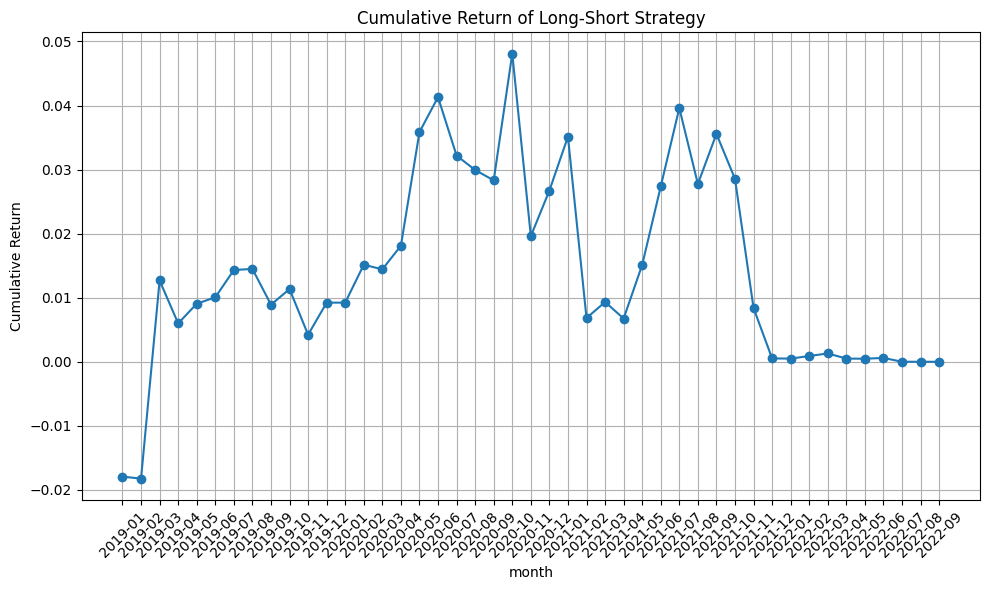

In [202]:
#LongShortReturns = LongShortReturns.sort_values('date')
longShortReturns['CumulativeReturn'] = (1 + longShortReturns['Long-Short return']).cumprod() 
longShortReturns['Label'] = longShortReturns['Month'].dt.strftime('%Y-%m')

# Plot
plt.figure(figsize=(10,6))
plt.plot(longShortReturns['Label'], longShortReturns['CumulativeReturn'], marker='o') 
plt.title("Cumulative Return of Long-Short Strategy")
plt.xlabel("month")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [203]:
import numpy as np
import pandas as pd

strat_returns = np.array(list(LSReturns.values()))
monthly_return_mean = strat_returns.mean()
monthly_return_std = strat_returns.std()
sharpe_ratio = monthly_return_mean / monthly_return_std
t_stat = sharpe_ratio * np.sqrt(len(strat_returns))


results = pd.DataFrame({
    'Mean': [monthly_return_mean],
    'Volatility': [monthly_return_std],
    'Sharpe Ratio': [sharpe_ratio],
    'T-statistics': [t_stat]
})

results


,Mean,Volatility,Sharpe Ratio,T-statistics
0,0.021149,0.615627,0.034353,0.23045


In [204]:
mean_annual_return = monthly_return_mean *12 
std_annual_return = np.sqrt(12) * monthly_return_std 
sharpe_annual_ratio = mean_annual_return / std_annual_return

annual_results = pd.DataFrame({
    'Annualized Mean Return': [mean_annual_return],
    'Annualized Volatility': [std_annual_return],
    'Annualized Sharpe Ratio': [sharpe_annual_ratio],
})

annual_results

,Annualized Mean Return,Annualized Volatility,Annualized Sharpe Ratio
0,0.253787,2.132594,0.119004


In [205]:
with pd.ExcelWriter('~/Desktop/summer25 intern/MOMs_by_Month_detailed2.xlsx', engine='xlsxwriter') as writer:
    results.to_excel(writer, sheet_name='overview', startrow=0, index=False)
    annual_results.to_excel(writer, sheet_name='overview', startrow=4, index=False)
    overview_df.to_excel(writer, sheet_name='overview', startrow=8, index=False) 

    for date, group in MOMs_to_excel.groupby('date'):
        sheet_name = date[:31]
        # 先写主表
        group[['ticker', 'adjStrikePrice', 'weightCall', 'weightPut', 'entry', 'expirationDate', 'return', 'MOM', 'signal']].to_excel(writer, sheet_name=sheet_name, index=False)
        
        # 获取当前sheet的workbook和worksheet对象
        workbook  = writer.book
        worksheet = writer.sheets[sheet_name]
        
        # 取当前sheet对应的top/bottom/LS return
        # 注意date的格式要跟Qhigh/LSReturns的key一致，如果Qhigh用的是datetime字符串就直接用date，否则用date.strftime('%Y-%m-%d')
        top_ret = Qhigh.get(date, '')
        bot_ret = Qlow.get(date, '')
        ls_ret  = LSReturns.get(date, '')

        # 可以写在表头上面，也可以写在最后面，这里举例写在表头上方
        worksheet.write(0, 10, 'Top Return')     # 写在K1
        worksheet.write(0, 11, top_ret)          # K2
        worksheet.write(1, 10, 'Bottom Return')  # K2
        worksheet.write(1, 11, bot_ret)
        worksheet.write(2, 10, 'LS Return')      # K3
        worksheet.write(2, 11, ls_ret)


NameError: name 'overview_df' is not defined

## tercile

In [ ]:
longShortReturns_Q3['Month'] = pd.to_datetime(longShortReturns_Q3['Month'])
longShortReturns_Q3['Year'] = longShortReturns_Q3['Month'].dt.year
yearly_summary_Q3 = longShortReturns_Q3.groupby('Year')['Long-Short return'].agg(['mean', 'std', 'min', 'max', 'count']) 
print(yearly_summary_Q3)

          mean       std       min       max  count
Year                                               
2019 -0.276967  0.370140 -0.936267  0.199843     11
2020  0.369288  0.706217 -1.012549  1.811928     12
2021  0.093765  0.461723 -0.620453  0.955827     12
2022 -0.032043  0.424082 -0.676115  0.559352      9


In [ ]:
import numpy as np
import pandas as pd

strat_returns_Q3 = np.array(list(LSReturns_Q3.values()))
monthly_return_mean_Q3 = strat_returns_Q3.mean()
monthly_return_std_Q3 = strat_returns_Q3.std()
sharpe_ratio_Q3 = monthly_return_mean_Q3 / monthly_return_std_Q3
t_stat_Q3 = sharpe_ratio_Q3 * np.sqrt(len(strat_returns_Q3))


results_Q3 = pd.DataFrame({
    'Mean': [monthly_return_mean_Q3],
    'Volatility': [monthly_return_std_Q3],
    'Sharpe Ratio': [sharpe_ratio_Q3],
    'T-statistics': [t_stat_Q3]
})

results_Q3


,Mean,Volatility,Sharpe Ratio,T-statistics
0,0.050491,0.546121,0.092454,0.613274


## Deciles

In [ ]:
longShortReturns_Q10['Month'] = pd.to_datetime(longShortReturns_Q10['Month'])
longShortReturns_Q10['Year'] = longShortReturns_Q10['Month'].dt.year
yearly_summary_Q10 = longShortReturns_Q10.groupby('Year')['Long-Short return'].agg(['mean', 'std', 'min', 'max', 'count']) 
print(yearly_summary_Q10)

          mean       std       min       max  count
Year                                               
2019  0.296423  0.833616 -1.252119  1.656952     11
2020  0.578510  1.226326 -0.737549  2.861447     12
2021 -0.202879  1.120201 -2.196575  1.220268     12
2022 -0.620305  1.140917 -2.984574  1.072253      9


In [ ]:
import numpy as np
import pandas as pd

strat_returns_Q10 = np.array(list(LSReturns_Q10.values()))
monthly_return_mean_Q10 = strat_returns_Q10.mean()
monthly_return_std_Q10 = strat_returns_Q10.std()
sharpe_ratio_Q10 = monthly_return_mean_Q10 / monthly_return_std_Q10
t_stat_Q10 = sharpe_ratio_Q10 * np.sqrt(len(strat_returns_Q10))


results_Q10 = pd.DataFrame({
    'Mean': [monthly_return_mean_Q10],
    'Volatility': [monthly_return_std_Q10],
    'Sharpe Ratio': [sharpe_ratio_Q10],
    'T-statistics': [t_stat_Q10]
})

results_Q10


,Mean,Volatility,Sharpe Ratio,T-statistics
0,0.04967,1.133575,0.043817,0.29065


In [ ]:
import pandas as pd
opt_210104 = pd.read_parquet("~/Desktop/summer25 intern/2021/optionmetrics_2021-01-04_nonzeroOI.parquet")

opt_210104

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix
0,5139.0,2021-01-04,CAE 210115C20000,1,2021-01-15,2020-12-17,C,20000.0,6.4,7.9,...,-26.00739,137042690.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
1,5139.0,2021-01-04,CAE 210115C22500,1,2021-01-15,2020-12-31,C,22500.0,3.9,4.3,...,<NA>,137042691.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
2,5139.0,2021-01-04,CAE 210115C25000,1,2021-01-15,2020-12-29,C,25000.0,1.8,2.0,...,-10.93867,137042692.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
3,5139.0,2021-01-04,CAE 210115C30000,1,2021-01-15,2020-12-31,C,30000.0,0.0,0.1,...,-3.945073,137042693.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
4,5139.0,2021-01-04,CAE 210115P30000,1,2021-01-15,2020-12-30,P,30000.0,3.3,3.6,...,-4.529408,137042700.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632930,215074.0,2021-01-04,CLVR 210820P10000,1,2021-08-20,2020-12-31,P,10000.0,3.1,3.5,...,-2.070807,137622730.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
632931,215074.0,2021-01-04,CLVR 210820P12500,1,2021-08-20,2020-12-31,P,12500.0,5.0,5.5,...,-2.152542,137622731.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
632932,215074.0,2021-01-04,CLVR 210820P15000,1,2021-08-20,2020-12-31,P,15000.0,6.9,8.0,...,-2.170253,137622732.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
632933,215074.0,2021-01-04,CLVR 210820P17500,1,2021-08-20,2020-12-21,P,17500.0,9.2,9.9,...,-1.881188,137622733.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>


In [ ]:
opt_210104['ticker'] = opt_210104['symbol'].str.split(' ').str[0]

opt_210104['ticker'].unique()

array(['CAE', 'FTS', 'WWR', ..., 'AAN', 'PTPI1', 'CLVR'],
      shape=(4581,), dtype=object)

In [ ]:
top20 = ['AMD', 'AMZN', 'AAPL', 'MSFT', 'NVDA', 'NFLX', 'GOOGL', 'TSLA', 'META', 'BABA']
opt_210104 = opt_210104[opt_210104['ticker'].isin(top20)]

opt_210104

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix,ticker
5818,101121.0,2021-01-04,AMD 210122C50000,1,2021-01-22,2020-12-21,C,50000.0,40.5,44.05,...,137458183.0,1.0,0.0,100.0,0,<NA>,w,<NA>,<NA>,AMD
5819,101121.0,2021-01-04,AMD 210122C55000,1,2021-01-22,2020-12-18,C,55000.0,35.5,39.05,...,137458184.0,1.0,0.0,100.0,0,<NA>,w,<NA>,<NA>,AMD
5820,101121.0,2021-01-04,AMD 210122C60000,1,2021-01-22,2021-01-04,C,60000.0,30.5,34.0,...,137370359.0,1.0,0.0,100.0,0,<NA>,w,<NA>,<NA>,AMD
5821,101121.0,2021-01-04,AMD 210108C100000,1,2021-01-08,2021-01-04,C,100000.0,0.19,0.2,...,137234995.0,1.0,0.0,100.0,0,<NA>,w,<NA>,<NA>,AMD
5822,101121.0,2021-01-04,AMD 210108C101000,1,2021-01-08,2021-01-04,C,101000.0,0.14,0.15,...,137273151.0,1.0,0.0,100.0,0,<NA>,w,<NA>,<NA>,AMD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494322,205204.0,2021-01-04,BABA 230120P420000,1,2023-01-20,2020-12-30,P,420000.0,198.8,201.8,...,135981277.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>,BABA
494323,205204.0,2021-01-04,BABA 230120P430000,1,2023-01-20,2020-12-28,P,430000.0,207.85,210.85,...,136312964.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>,BABA
494324,205204.0,2021-01-04,BABA 230120P440000,1,2023-01-20,2020-11-27,P,440000.0,217.4,219.85,...,136403132.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>,BABA
494325,205204.0,2021-01-04,BABA 230120P450000,1,2023-01-20,2020-11-30,P,450000.0,226.45,229.2,...,136445790.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>,BABA
